### Cell 1: Setup & Data Ingestion  
Load necessary libraries, configure paths, and read in all raw call-data CSV files.

In [319]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob as glob
import re
from pathlib import Path
import math
import io
import imageio

In [321]:
DATA_DIR = Path("/Users/staspupkov/Documents/24-25/Spring 25/DSCI410/CAD_data_through_2025")
FILE_PATTERN = "class_data_*.csv"
EXPANSION_DATE = pd.Timestamp("2017-01-01 05:00")

In [323]:
# Plot styling
sns.set_theme(style="whitegrid", font_scale=1.1)

In [324]:
# Discover & load
files = sorted(DATA_DIR.glob(FILE_PATTERN))
print(f"Found {len(files)} CSV files in {DATA_DIR}")
dfs = [
    pd.read_csv(f, parse_dates=["calltime"], low_memory=False)
    for f in files
]
master_df = pd.concat(dfs, ignore_index=True)

Found 12 CSV files in /Users/staspupkov/Documents/24-25/Spring 25/DSCI410/CAD_data_through_2025


In [325]:
print("Master DF shape:", master_df.shape)
master_df.head(3)

Master DF shape: (1488577, 20)


yr service   inci_id            calltime case_id callsource  \
0  2014    LAW   14000001 2014-01-01 00:00:05     NaN       SELF   
1  2014    LAW   14000003 2014-01-01 00:01:50     NaN       SELF   
2  2014    LAW   14000006 2014-01-01 00:05:17     NaN      PHONE   

         nature closecode                        closed_as  secs_to_disp  \
0  TRAFFIC STOP      UTC   UNIFORM TRAFFIC CITATION ISSUED           1.0   
1  TRAFFIC STOP      ADVI                          ADVISED           0.0   
2       DISPUTE      ADVI                          ADVISED         219.0   

   secs_to_arrv  secs_to_close  disp  arrv  beat priority    zip primeunit  \
0           1.0            690     1     1  EP05        6  97402    5Z51     
1           0.0            170     1     1  EP02        6  97401    5T82     
2         596.0           1444     1     1  EP01        3  97401    5E93     

   units_dispd  units_arrived  
0            1              1  
1            2              2  
2            3              2

In [327]:
df_subset = master_df[["calltime", "nature", "primeunit"]]
df_subset

calltime                     nature primeunit
0       2014-01-01 00:00:05               TRAFFIC STOP    5Z51  
1       2014-01-01 00:01:50               TRAFFIC STOP    5T82  
2       2014-01-01 00:05:17                    DISPUTE    5E93  
3       2014-01-01 00:08:36               TRAFFIC STOP    5E31  
4       2014-01-01 00:10:21                      THEFT    6E45  
...                     ...                        ...       ...
1488572 2025-04-22 23:34:57  GAS LEAK, LARGE STRUCTURE       NaN
1488573 2025-04-22 23:48:35           BEAT INFORMATION    6E31  
1488574 2025-04-22 23:51:33             TRASH BIN FIRE    6E64  
1488575 2025-04-22 23:59:31              CHECK WELFARE       NaN
1488576 2025-04-18 11:12:00                   BURGLARY       NaN

[1488577 rows x 3 columns]

In [328]:
# Parse timestamps & flag pre/post expansion
master_df = master_df.copy()

In [329]:
# Parse with coercion & count errors
parsed = pd.to_datetime(master_df['calltime'], errors='coerce')
n_bad   = parsed.isna().sum()
print(f"Dropped {n_bad} rows due to unparseable timestamps.")
master_df['calltime'] = parsed
master_df = master_df.dropna(subset=['calltime'])

Dropped 0 rows due to unparseable timestamps.


In [330]:
# Extract temporal features
master_df['date']           = master_df['calltime'].dt.date
master_df['hour']           = master_df['calltime'].dt.hour
master_df['month']          = master_df['calltime'].dt.month
master_df['post_expansion'] = master_df['calltime'] >= EXPANSION_DATE

master_df.head(3)

yr service   inci_id            calltime case_id callsource  \
0  2014    LAW   14000001 2014-01-01 00:00:05     NaN       SELF   
1  2014    LAW   14000003 2014-01-01 00:01:50     NaN       SELF   
2  2014    LAW   14000006 2014-01-01 00:05:17     NaN      PHONE   

         nature closecode                        closed_as  secs_to_disp  ...  \
0  TRAFFIC STOP      UTC   UNIFORM TRAFFIC CITATION ISSUED           1.0  ...   
1  TRAFFIC STOP      ADVI                          ADVISED           0.0  ...   
2       DISPUTE      ADVI                          ADVISED         219.0  ...   

   beat  priority    zip  primeunit units_dispd units_arrived        date  \
0  EP05         6  97402     5Z51             1             1  2014-01-01   
1  EP02         6  97401     5T82             2             2  2014-01-01   
2  EP01         3  97401     5E93             3             2  2014-01-01   

  hour  month  post_expansion  
0    0      1           False  
1    0      1           False  
2    0      1           False  

[3 rows x 24 columns]

In [331]:
cahoots_pattern = re.compile(
    r'^(1J77|3J79|3J78|4J79|3J81|3J76|2J28|2J29|CAHOOTS?|CAHOT)$',
    flags=re.IGNORECASE
)

def classify_unit(call_sign):
    """
    Return 'CAHOOTS' if call_sign matches one of the known CAHOOTS unit codes,
    'unknown' if null, else 'NOT CAHOOTS'.
    """
    if pd.isna(call_sign):
        return "unknown"
    cs = call_sign.strip()
    return "CAHOOTS" if cahoots_pattern.fullmatch(cs) else "NOT CAHOOTS"

In [332]:
# Apply to your primeunit (or whichever column holds the unit call-sign)
master_df['Unit Type'] = master_df['primeunit'].apply(classify_unit)

In [333]:
# Quick sanity check: how many of each?
print(master_df['Unit Type'].value_counts(dropna=False))

Unit Type
NOT CAHOOTS    950511
unknown        355485
CAHOOTS        182581
Name: count, dtype: int64


In [334]:
print(master_df['calltime'].dtype)

datetime64[ns]


In [335]:
daily = (
    master_df
      # only include known responders if you like:
      .loc[master_df['Unit Type'].isin(['CAHOOTS','NOT CAHOOTS'])]
      .groupby(['date','Unit Type'])
      .size()
      .unstack(fill_value=0)         # zero where no calls on that day
)

In [336]:
# 3. Reindex to a complete date range so no gaps
full_idx = pd.date_range(daily.index.min(), daily.index.max(), freq='D')
daily = daily.reindex(full_idx, fill_value=0)
daily.index.name = 'date'

In [339]:
daily_7d = daily.rolling(window=7, center=True).mean()

In [340]:
# 4. Quick sanity-check
print("Sample daily counts:")
display(daily.head())
print("\nSample 7-day rolling averages:")
display(daily_7d.head())

Sample daily counts:


Unit Type   CAHOOTS  NOT CAHOOTS
date                            
2014-01-01       24          307
2014-01-02       21          301
2014-01-03       22          276
2014-01-04       20          234
2014-01-05       34          152


Sample 7-day rolling averages:


Unit Type     CAHOOTS  NOT CAHOOTS
date                              
2014-01-01        NaN          NaN
2014-01-02        NaN          NaN
2014-01-03        NaN          NaN
2014-01-04  24.857143   236.571429
2014-01-05  24.857143   222.000000

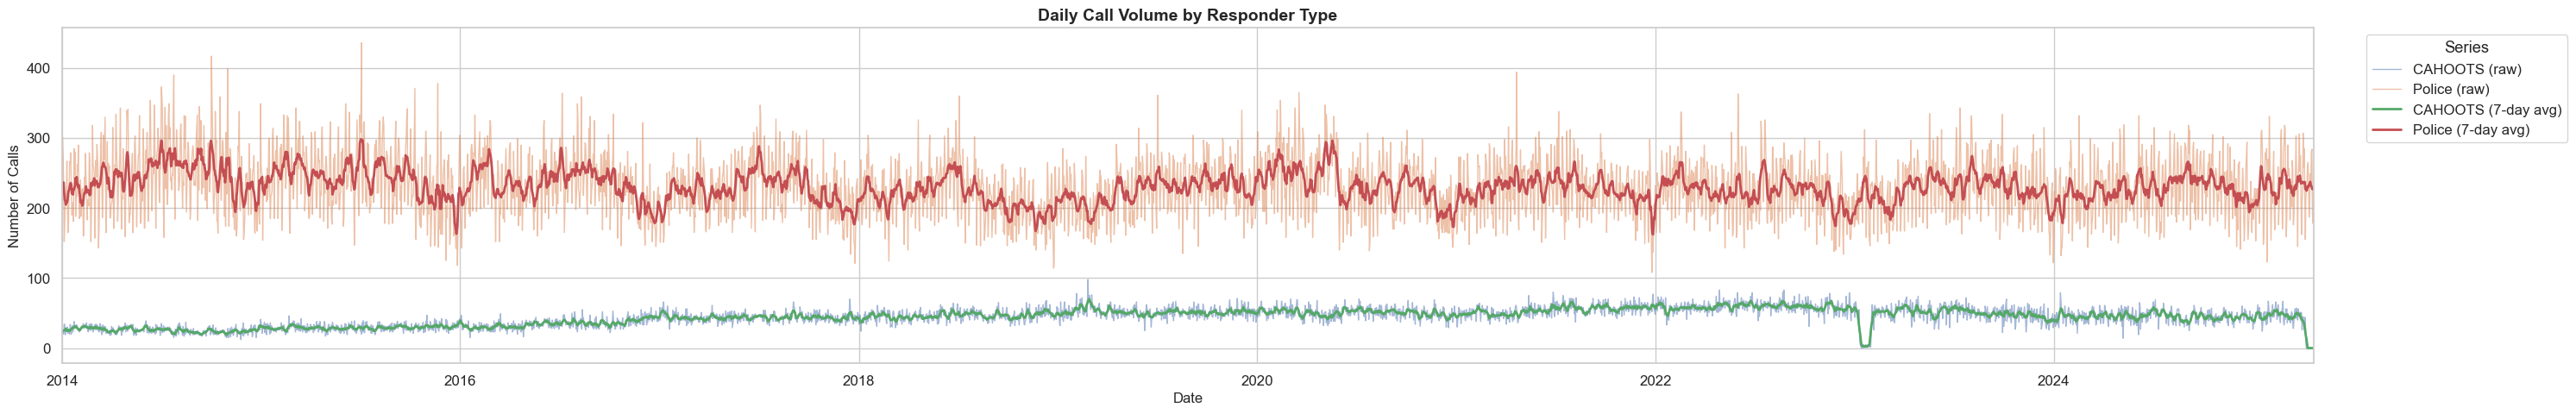

In [341]:
fig, ax = plt.subplots(figsize=(30,5))

# raw daily counts
daily.plot(ax=ax, alpha=0.5, linewidth=1)

# 7-day rolling mean
daily_7d.plot(ax=ax, linewidth=2)

# labels & legend
ax.set_title("Daily Call Volume by Responder Type", fontsize=14, weight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Number of Calls", fontsize=12)
ax.legend(
    ['CAHOOTS (raw)', 'Police (raw)',
     'CAHOOTS (7-day avg)', 'Police (7-day avg)'],
    title="Series",
    bbox_to_anchor=(1.02, 1), loc='upper left'
)

plt.tight_layout()
plt.show()

**Raw Data**
\
Looking at the raw data above, it is hard to make out anything of significance in a quick glance. We can see that there was 0 CAHOOTS calls for a little while in 2023? What is that all about?

#### Classify Incident Natures & Filter to CAHOOTS-Dominant
We’ll define “CAHOOTS-dominant” as those natures with ≥51% of calls handled by CAHOOTS and at least 10 total calls.

In [349]:
master_df['nature_clean'] = (
    master_df['nature']
    .str.upper()              # ensure consistent uppercase
    .str.strip()              # remove leading/trailing whitespace
    .str.replace(r',\s*CAHOOTS$', '', regex=True)  # drop any ", CAHOOTS" suffix
)

In [350]:
core = master_df.copy()

In [354]:
# 1. Pivot counts by nature & responder
pivot = (
    core
    .groupby(['nature_clean','Unit Type'])
    .size()
    .unstack(fill_value=0)
)

for col in ['CAHOOTS','NOT CAHOOTS']:
    pivot[col] = pivot.get(col, 0)

In [357]:
pivot['total']        = pivot['CAHOOTS'] + pivot['NOT CAHOOTS']
pivot['share_cahoots']= pivot['CAHOOTS'] / pivot['total']

In [360]:
min_total     = 10      # drop natures with fewer than this many total calls
mostly_thresh = 0.51    # CAHOOTS share threshold for “Mostly CAHOOTS”
even_thresh   = 0.20    # lower bound for “Roughly Even”

In [361]:
conds = [
    pivot['total'] < min_total,
    pivot['share_cahoots'] >= mostly_thresh,
    pivot['share_cahoots'].between(even_thresh, mostly_thresh, inclusive='left'),
    pivot['share_cahoots'] < even_thresh,
]
choices = [np.nan, 'Mostly CAHOOTS', 'Roughly Even', 'Mostly NOT CAHOOTS']

In [362]:
pivot['class'] = np.select(conds, choices)

In [364]:
class_dict = (
    pivot
    .reset_index()
    .dropna(subset=['class'])
    .groupby('class')['nature_clean']
    .agg(list)
    .to_dict()
)

In [365]:
mostly_cahoots = class_dict.get('Mostly CAHOOTS', [])
even_natures    = class_dict.get('Roughly Even', [])
not_cahoots     = class_dict.get('Mostly NOT CAHOOTS', [])
print(f"Mostly CAHOOTS ({len(mostly_cahoots)}):\n", mostly_cahoots, "\n")
print(f"Roughly Even ({len(even_natures)}):\n", even_natures, "\n")
print(f"Mostly NOT CAHOOTS ({len(not_cahoots)}):\n", "\n")

Mostly CAHOOTS (14):
 ['ASSIST FD', 'ASSIST PD', 'ASSIST PUBLIC- POLICE', 'CHECK WELFARE', 'DEATH MESSAGE', 'DISORIENTED SUBJECT', 'EMERGENCY MESSAGE', 'FOUND SYRINGE', 'INFO / ATL', 'INTOXICATED SUBJECT', 'POISONING', 'PUBLIC ASSIST', 'SUICIDAL SUBJECT', 'TRANSPORT'] 

Roughly Even (4):
 ['ASSIST FIRE DEPARTMENT', 'LOST SUBJECT', 'MENTAL SUBJECT', 'SUBJECT DOWN'] 

Mostly NOT CAHOOTS (241):
 



In [366]:
core['nature_clean'] = (
    core['nature_clean']
    .str.replace(r',\s*CAHOOTS$', '', regex=True)
    .str.strip()
)

In [368]:
to_drop = [
    # 'ASSIST PUBLIC- POLICE',
    # 'ASSIST FD',
    # 'ASSIST PD',
    # 'PUBLIC ASSIST',
    # 'TRAFFIC HAZARD',
    # 'TRANSPORT'
]

In [370]:
core = core[~core['nature_clean'].isin(to_drop)].copy()
print("After cleanup, unique core natures:", core['nature_clean'].unique())

After cleanup, unique core natures: ['TRAFFIC STOP' 'DISPUTE' 'THEFT' 'ILLEGAL BURNING' 'PERSON STOP' 'DWS'
 'LOUD NOISE' 'THEFT FROM VEHICLE' 'ASSAULT' 'DUII' 'MINOR IN POSSESSION'
 'CRIMINAL TRESPASS' 'ATTEMPT TO LOCATE DRUNK DRIVER'
 'ASSIST OREGON STATE POLICE' 'SUBJECT DOWN' 'LOCATE MISSING PERSON'
 'TRANSPORT' 'DISORDERLY SUBJECT' 'FIGHT' 'BEAT INFORMATION'
 'WRONG WAY DRIVER' 'VEHICLE/PEDESTRIAN CRASH' 'CRIMINAL MISCHIEF'
 'DRUG INFO' 'ACCIDENT BIKE' 'INTOXICATED SUBJECT' 'WATER PROBLEM'
 'CHECK WELFARE' 'DEATH MESSAGE' 'PATROL CHECK' 'INCOMPLETE CALL'
 'ASSIST FIRE DEPARTMENT' 'TRAFFIC HAZARD' 'DISABLED VEHICLE'
 'RUNAWAY JUVENILE' 'BURGLARY' 'DAMAGE CITY PROPERTY' 'ALARM HOLD UP'
 'FOUND PROPERTY' 'RECOVERED STOLEN VEHICLE' 'RECKLESS DRIVIING'
 'FOLLOW UP' 'LOST PROPERTY' 'HAZARD SAFETY' 'THEFT OF IDENTITY'
 'NATURAL GAS LEAK' 'RAPE' 'ATTEMPT TO LOCATE' 'DISPUTE FAMILY'
 'HARASSMENT' 'ABANDONED VEHICLE' 'DOG AT LARGE' 'LOCATION STOLEN VEHICLE'
 'ASSIST PUBLIC- POLICE' 'DRIVING

In [377]:
core_cahoots_df = core[core['nature_clean'].isin(mostly_cahoots)].copy()
print("core_cahoots_df shape:", core_cahoots_df.shape)
print("Final natures:", core_cahoots_df['nature_clean'].unique())

core_cahoots_df shape: (238429, 26)
Final natures: ['TRANSPORT' 'INTOXICATED SUBJECT' 'CHECK WELFARE' 'DEATH MESSAGE'
 'ASSIST PUBLIC- POLICE' 'SUICIDAL SUBJECT' 'POISONING' 'FOUND SYRINGE'
 'DISORIENTED SUBJECT' 'EMERGENCY MESSAGE' 'PUBLIC ASSIST' 'ASSIST PD'
 'ASSIST FD' 'INFO / ATL']


### Daily Call Volume by Year (CAHOOTS-Dominant Natures)
Loop through each calendar year and plot raw daily counts + 7-day rolling mean in a simple for-loop.

In [380]:
daily_core = (
    core_cahoots_df
      .groupby(["date","Unit Type"])
      .size()
      .unstack(fill_value=0)
)
full_idx = pd.date_range(daily_core.index.min(), daily_core.index.max(), freq="D")
daily_core = daily_core.reindex(full_idx, fill_value=0)
daily_core.index.name = "date"

In [382]:
daily_core_7d = daily_core.rolling(window=7, center=True).mean()

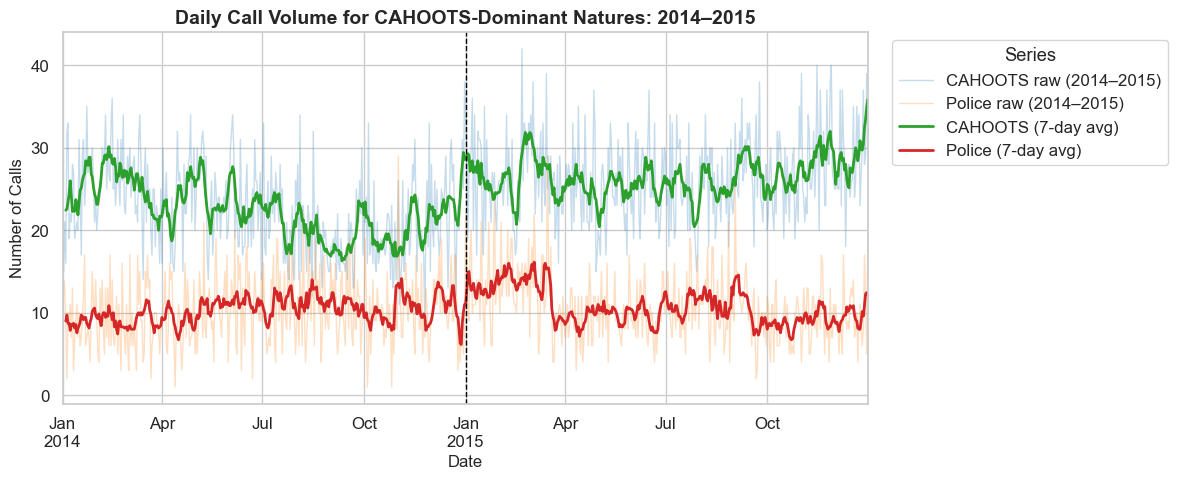

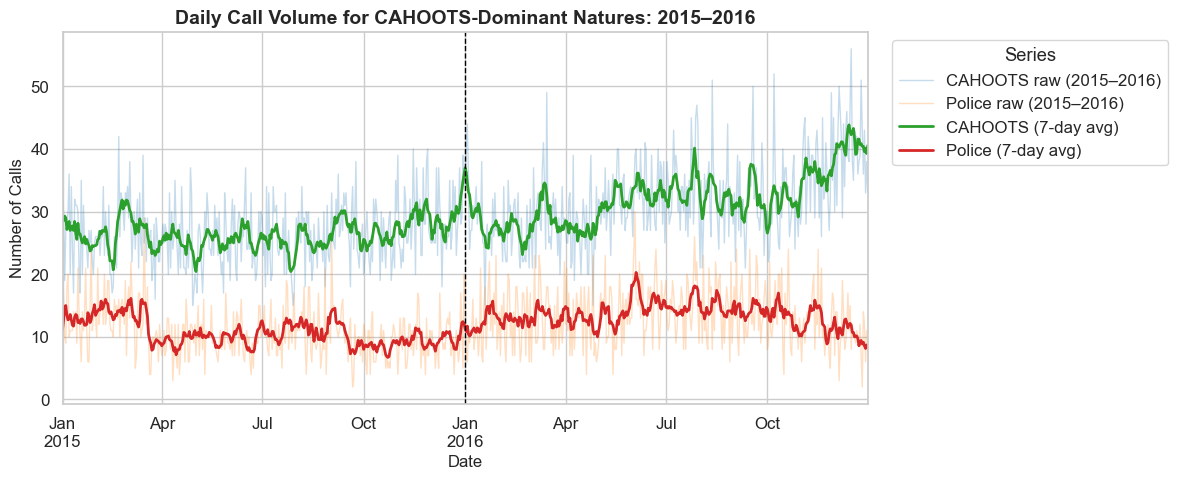

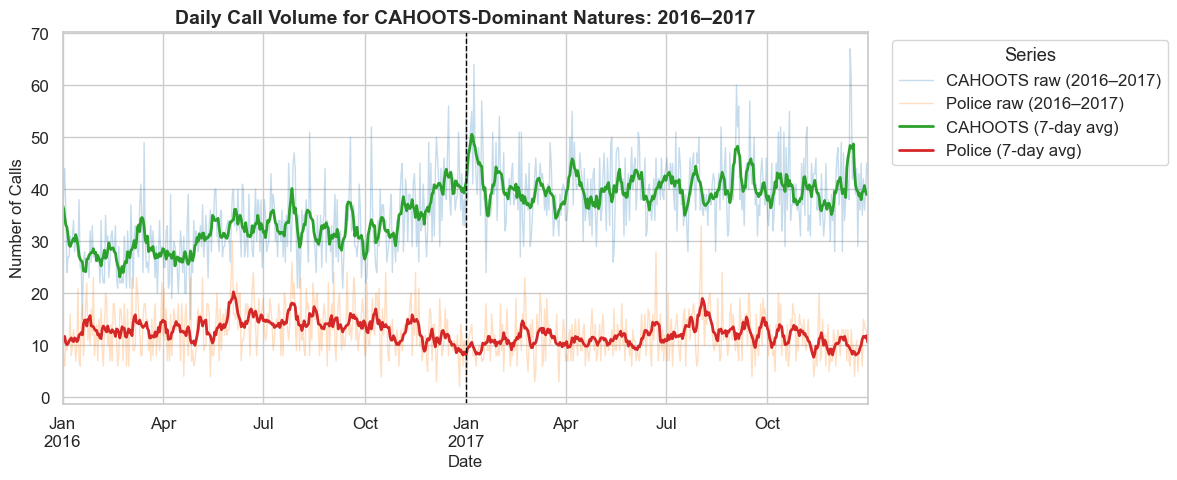

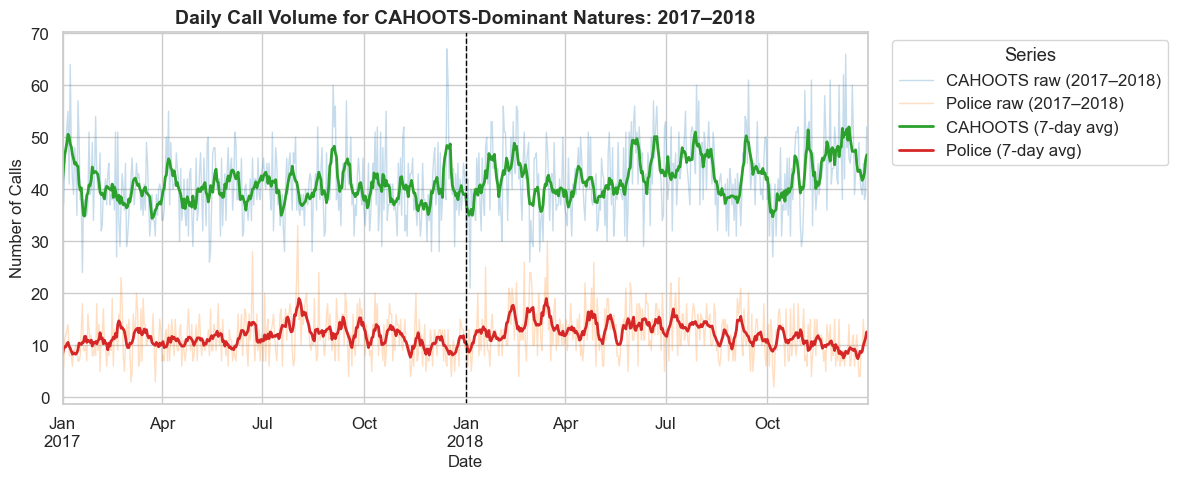

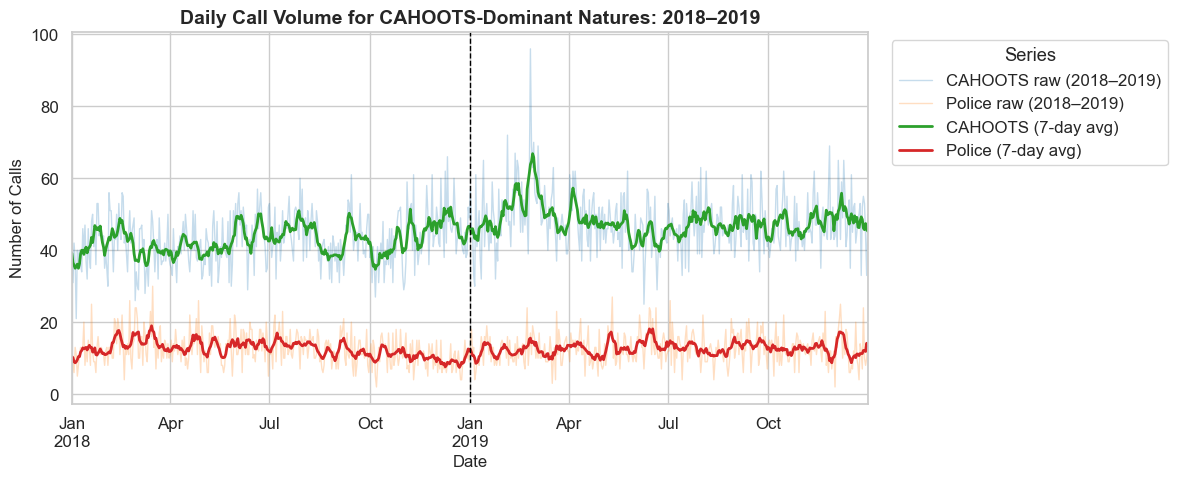

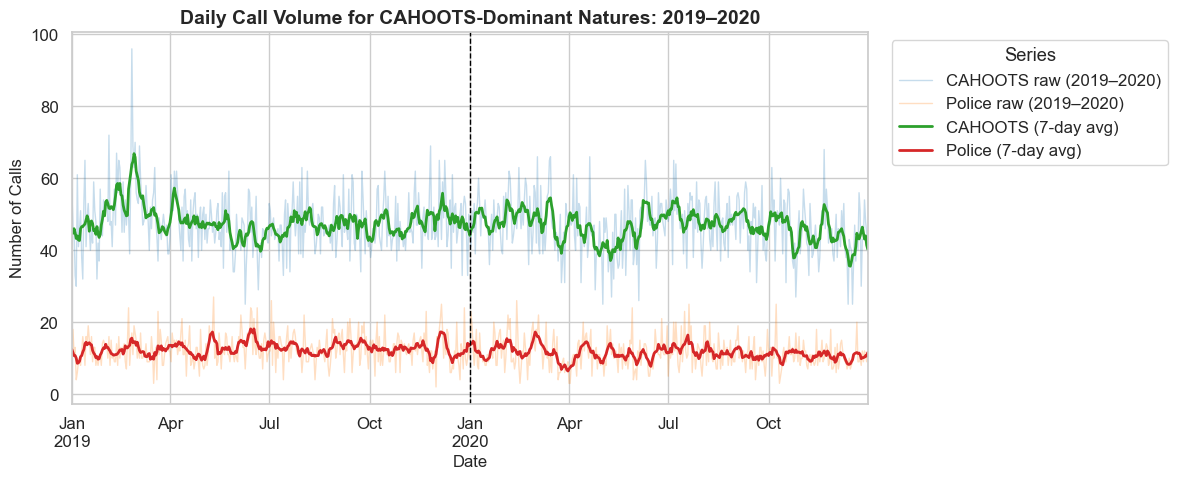

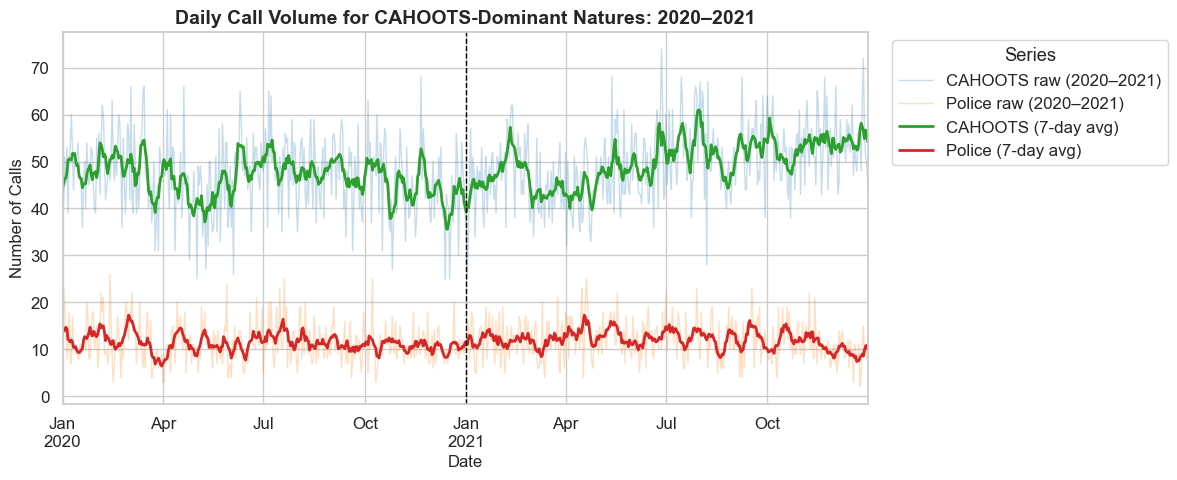

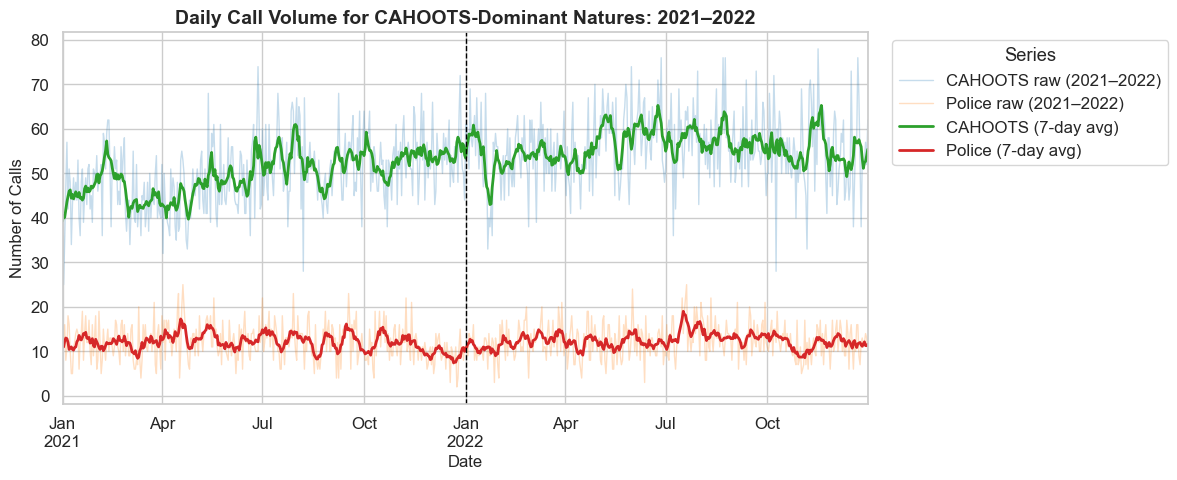

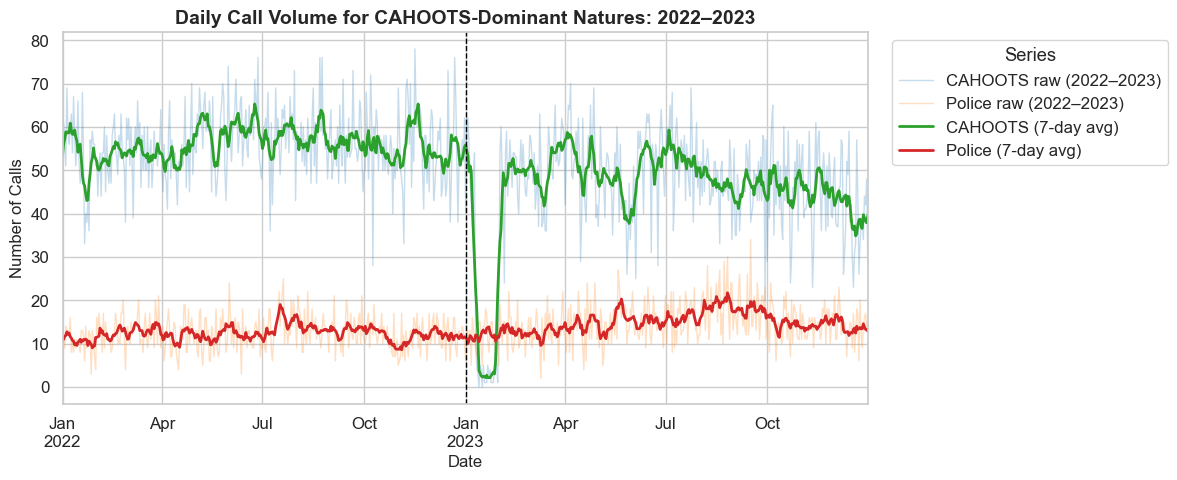

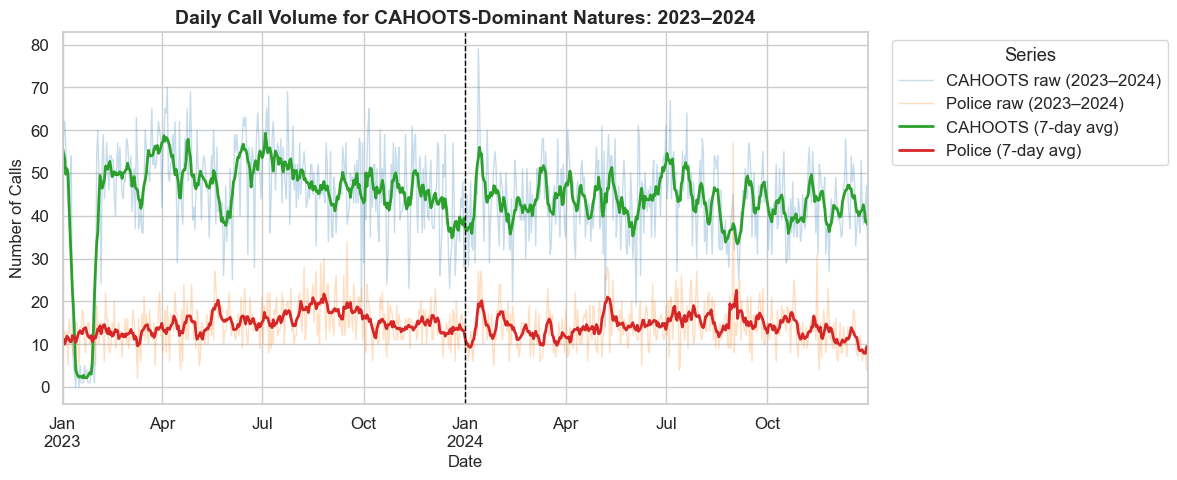

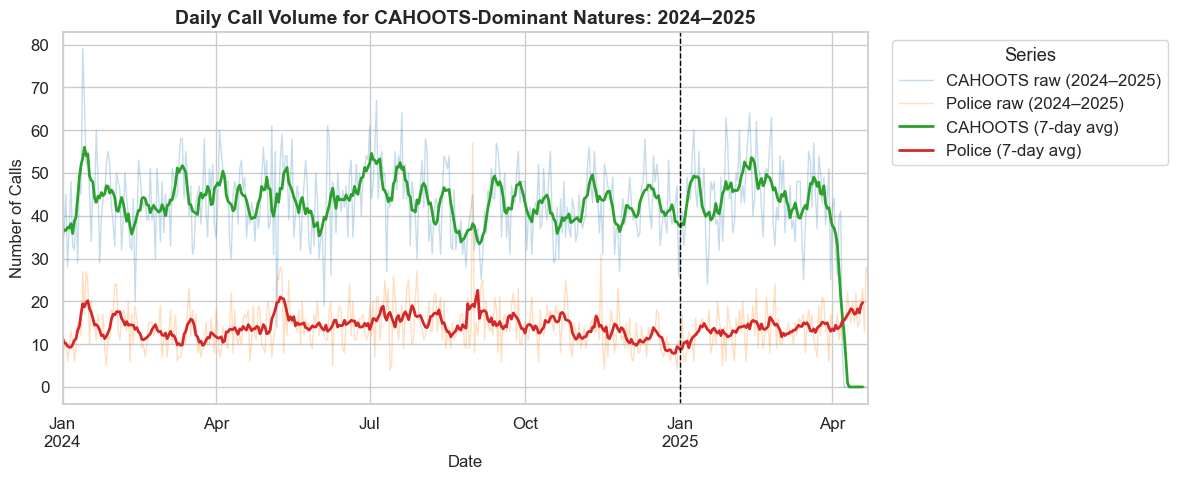

In [390]:
years = sorted(daily_core.index.year.unique())

for i in range(len(years) - 1):
    y1 = years[i]
    y2 = years[i + 1]

    # Subset raw data for both years in the pair
    mask_raw = daily_core.index.year.isin([y1, y2])
    raw_pair = daily_core.loc[mask_raw]

    # Subset smoothed data for both years in the pair
    mask_smooth = daily_core_7d.index.year.isin([y1, y2])
    smooth_pair = daily_core_7d.loc[mask_smooth]

    if raw_pair.empty:
        continue

    # Create the figure
    plt.close("all")
    fig, ax = plt.subplots(figsize=(12, 5))

    # Plot CAHOOTS raw (both years combined)
    raw_pair["CAHOOTS"].plot(
        ax=ax,
        color="tab:blue",
        alpha=0.25,
        linewidth=1,
        label=f"CAHOOTS raw ({y1}–{y2})"
    )
    # Plot Police raw (both years combined)
    raw_pair["NOT CAHOOTS"].plot(
        ax=ax,
        color="tab:orange",
        alpha=0.25,
        linewidth=1,
        label=f"Police raw ({y1}–{y2})"
    )
    # Plot CAHOOTS 7-day avg (both years combined)
    smooth_pair["CAHOOTS"].plot(
        ax=ax,
        color="tab:green",
        linewidth=2,
        label="CAHOOTS (7-day avg)"
    )
    # Plot Police 7-day avg (both years combined)
    smooth_pair["NOT CAHOOTS"].plot(
        ax=ax,
        color="tab:red",
        linewidth=2,
        label="Police (7-day avg)"
    )

    # Draw a vertical black line at January 1 of the second year (boundary between y1 and y2)
    boundary_date = pd.Timestamp(f"{y2}-01-01")
    ax.axvline(boundary_date, color="black", linewidth=1, linestyle="--")

    # Formatting
    ax.set_title(
        f"Daily Call Volume for CAHOOTS-Dominant Natures: {y1}–{y2}",
        fontsize=14,
        weight="bold"
    )
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Number of Calls", fontsize=12)
    ax.legend(title="Series", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


### Daily Call Volume in the 3 am–10 am Window
Filter to calls between 03:00 and 10:00, aggregate by day & responder, fill gaps, compute a 7-day centered rolling mean, and plot.


In [194]:
# 1. Isolate the 3 am–10 am window
window_df = core[(core['hour'] >= 3) & (core['hour'] < 10)].copy()

In [196]:
daily_win = (
    window_df
    .groupby(['date','Unit Type'])
    .size()
    .unstack(fill_value=0)
)

In [197]:
full_idx = pd.date_range(daily_win.index.min(), daily_win.index.max(), freq='D')
daily_win = daily_win.reindex(full_idx, fill_value=0)
daily_win.index.name = 'date'

In [200]:
daily_win_7d = daily_win.rolling(window=7, center=True).mean()

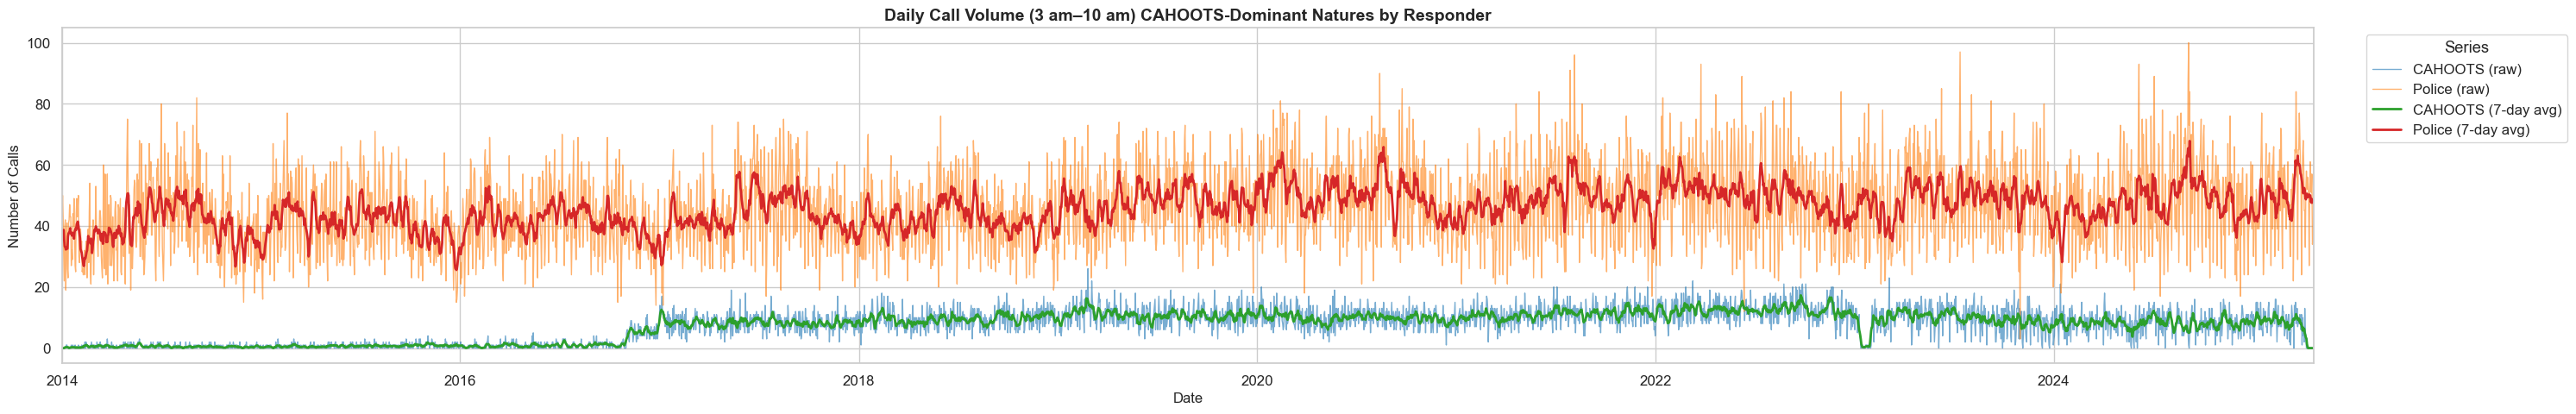

In [201]:
fig, ax = plt.subplots(figsize=(30, 5))

# raw
daily_win['CAHOOTS'].plot(ax=ax, color='tab:blue',  alpha=0.6, linewidth=1, label='CAHOOTS (raw)')
daily_win['NOT CAHOOTS'].plot(ax=ax, color='tab:orange',alpha=0.6, linewidth=1, label='Police (raw)')

# smoothed
daily_win_7d['CAHOOTS'].plot(ax=ax, color='tab:green', linewidth=2, label='CAHOOTS (7-day avg)')
daily_win_7d['NOT CAHOOTS'].plot(ax=ax, color='tab:red',   linewidth=2, label='Police (7-day avg)')

# styling
ax.set_title("Daily Call Volume (3 am–10 am) CAHOOTS-Dominant Natures by Responder", fontsize=14, weight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Number of Calls", fontsize=12)
ax.legend(title="Series", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Daily Call Volume (3 am–10 am) for CAHOOTS-Dominant Natures

In [203]:
window_core = core_cahoots_df[
    (core_cahoots_df['hour'] >= 3) &
    (core_cahoots_df['hour']  < 10)
].copy()

In [204]:
daily_core_win = (
    window_core
      .groupby(['date', 'Unit Type'])
      .size()
      .unstack(fill_value=0)
)

In [208]:
full_idx = pd.date_range(daily_core_win.index.min(),
                         daily_core_win.index.max(),
                         freq='D')
daily_core_win = daily_core_win.reindex(full_idx, fill_value=0)
daily_core_win.index.name = 'date'


In [209]:
daily_core_win_7d = daily_core_win.rolling(window=7, center=True).mean()

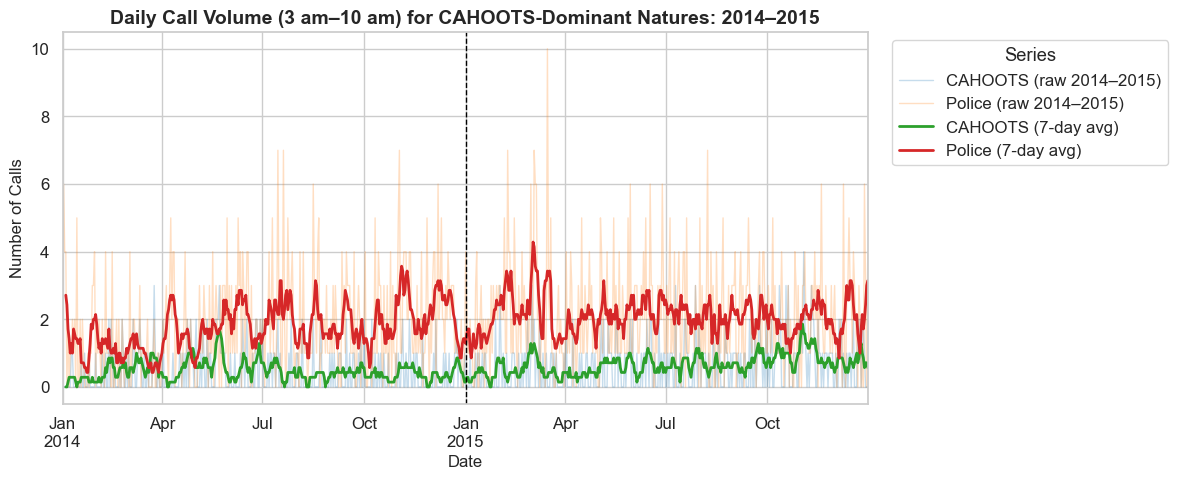

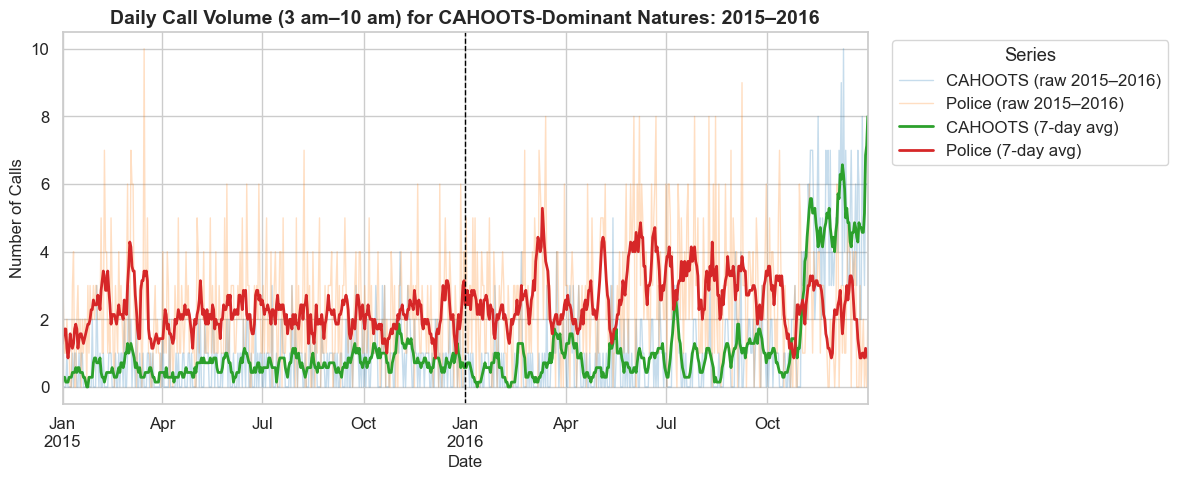

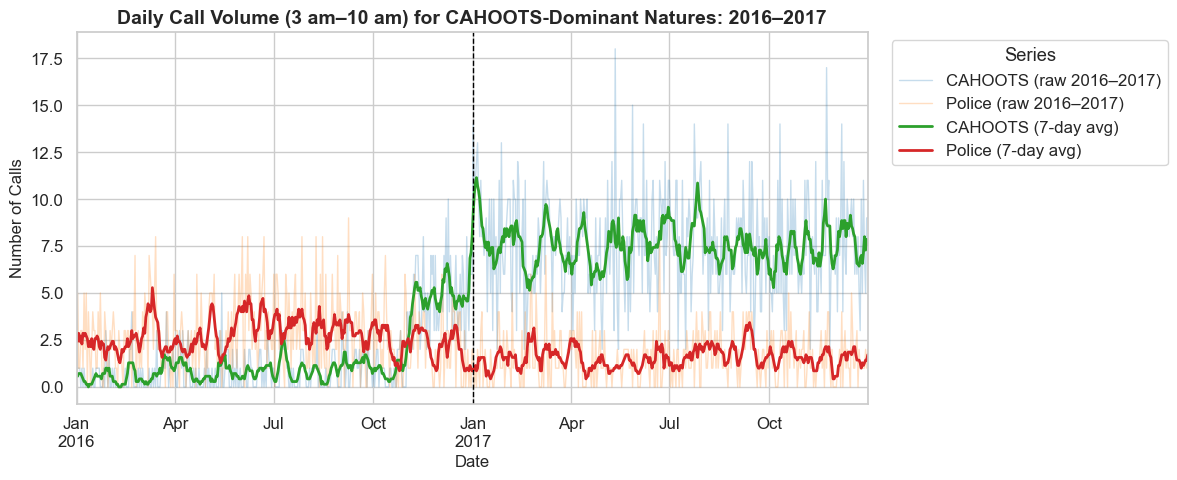

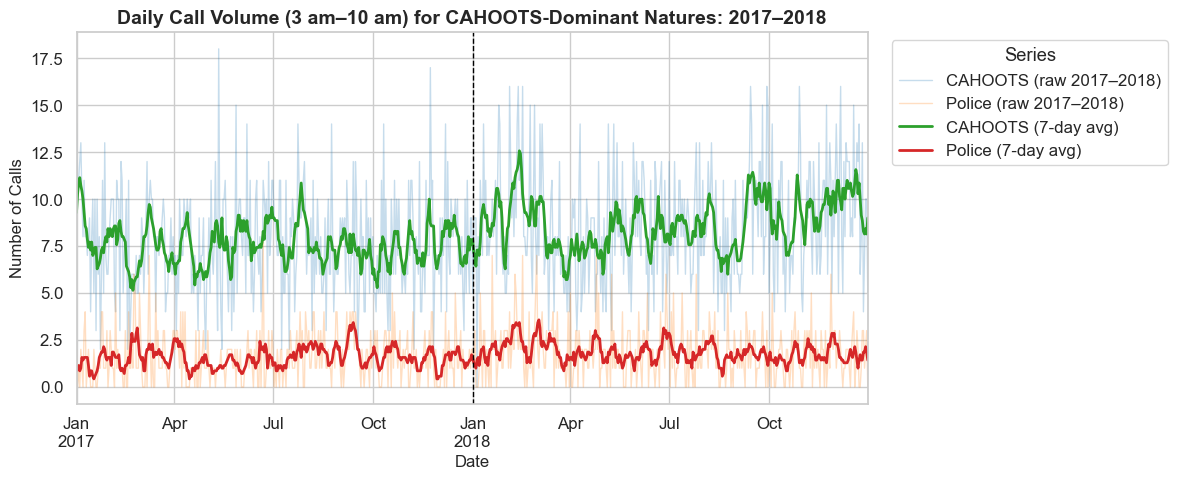

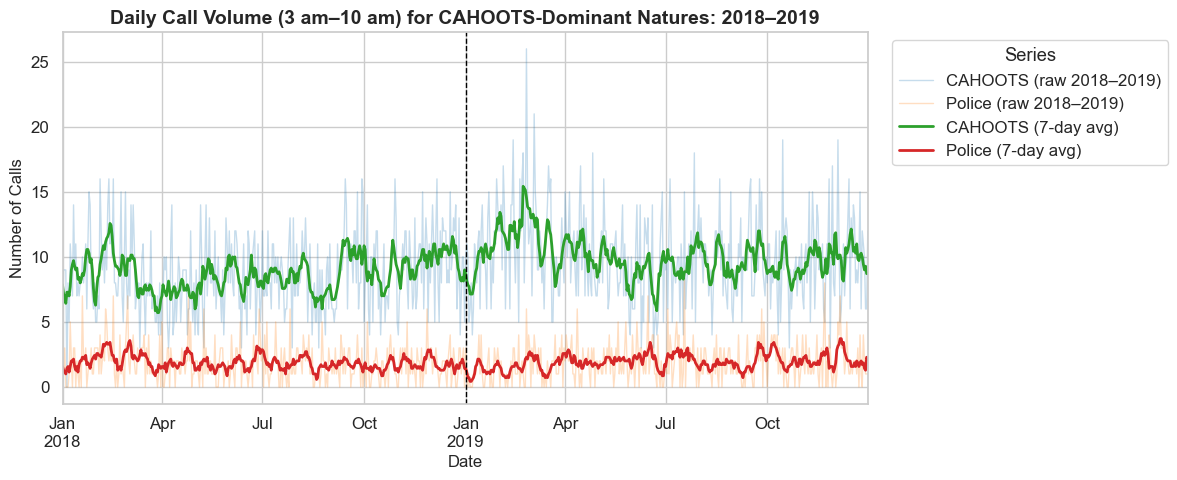

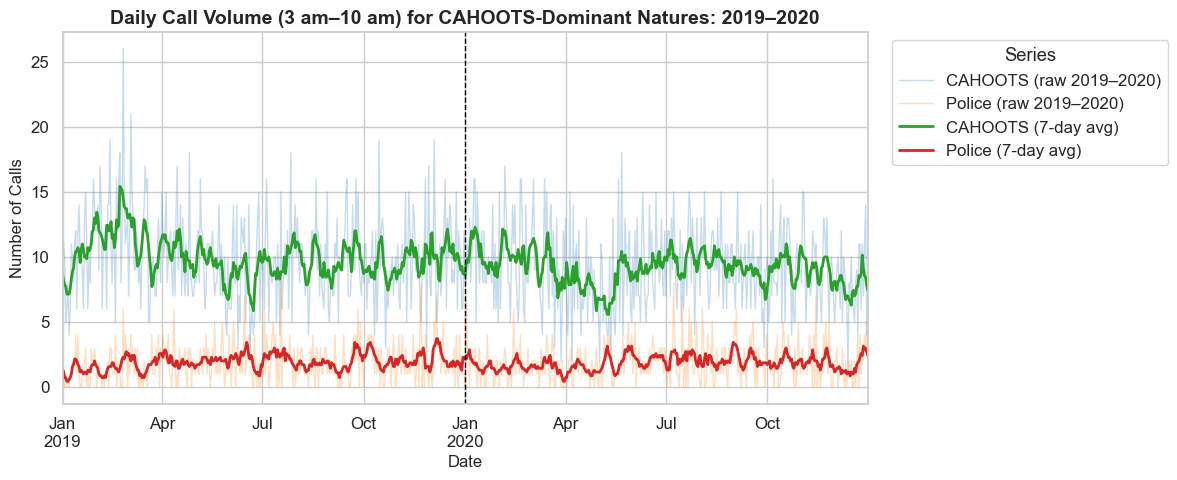

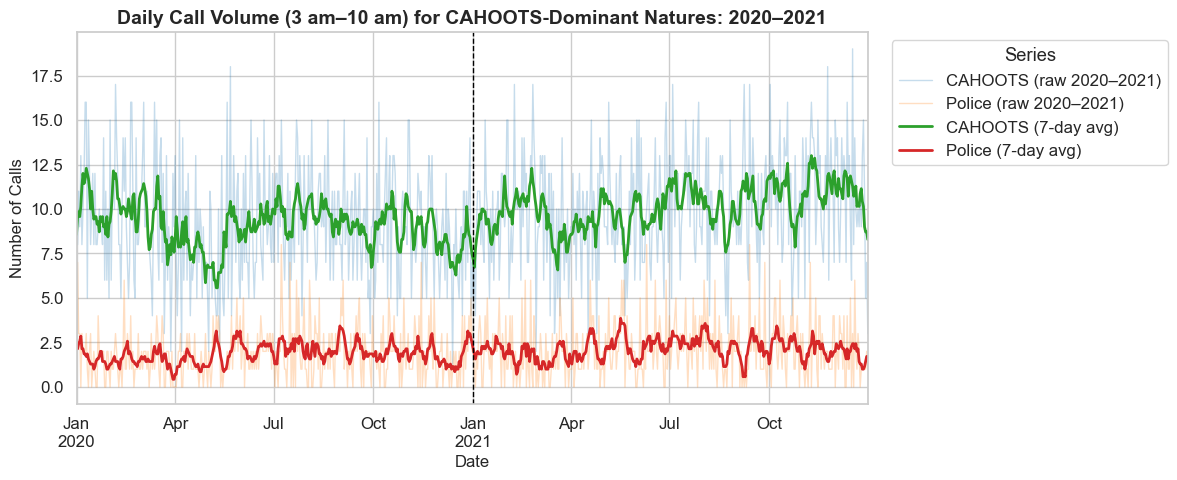

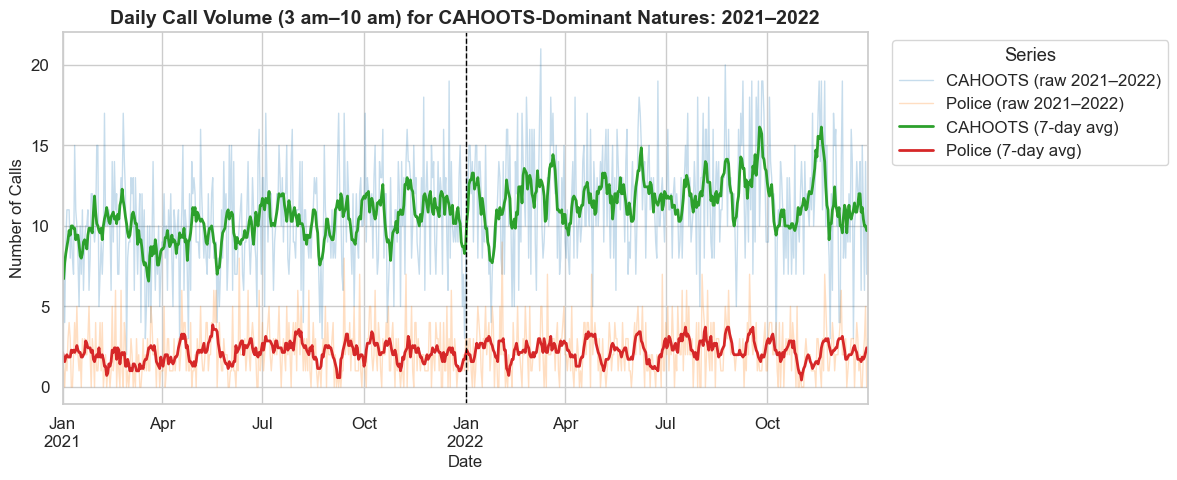

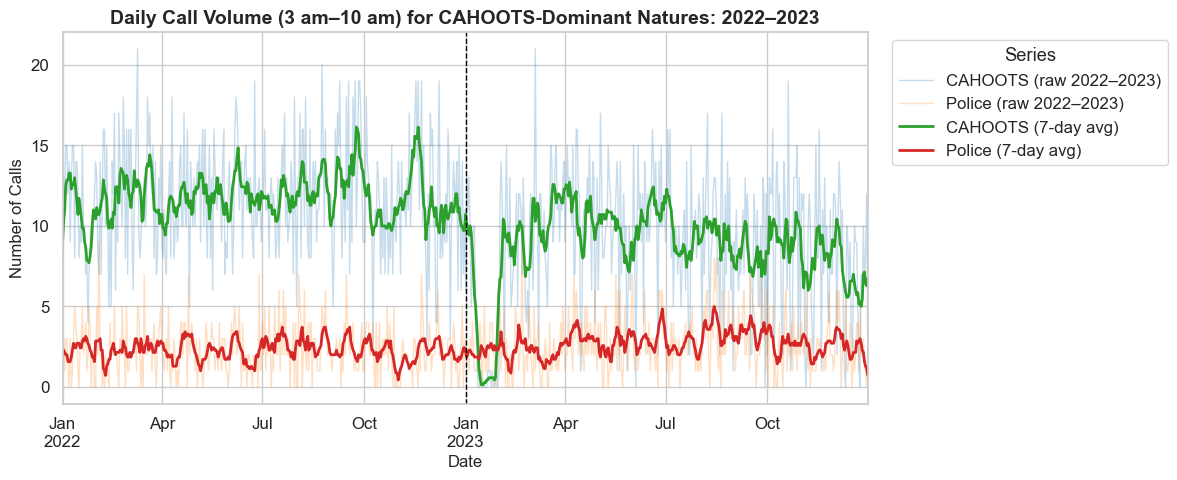

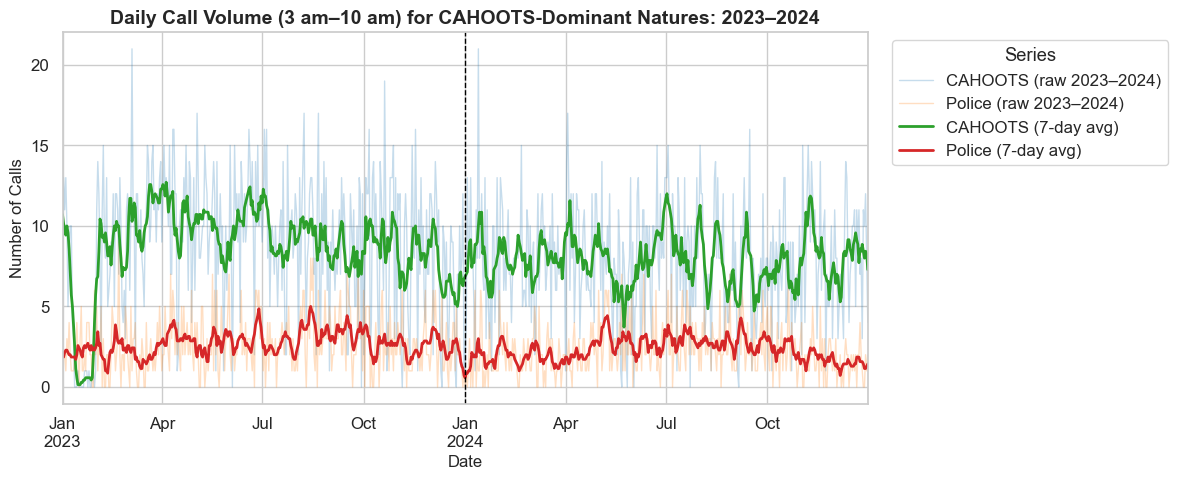

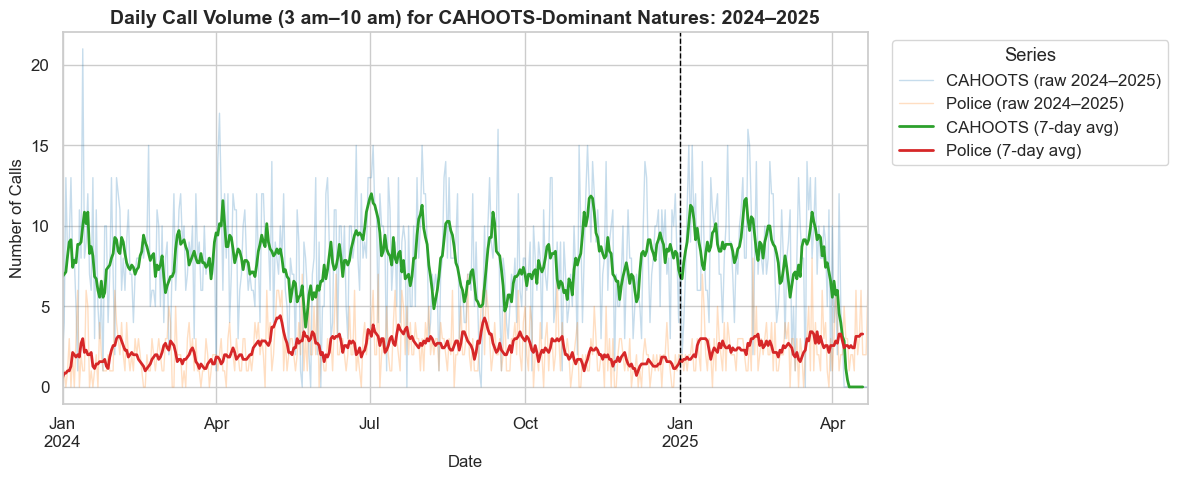

In [392]:
# (1) Get the sorted list of unique years in the filtered index
years = sorted(daily_core_win.index.year.unique())

# (2) Loop over consecutive‐year pairs: (years[0], years[1]), (years[1], years[2]), etc.
for i in range(len(years) - 1):
    y1 = years[i]
    y2 = years[i + 1]

    # Subset raw data for both years in the pair
    mask_raw   = daily_core_win.index.year.isin([y1, y2])
    raw_pair   = daily_core_win.loc[mask_raw]

    # Subset smoothed data for both years in the pair
    mask_smooth = daily_core_win_7d.index.year.isin([y1, y2])
    smooth_pair = daily_core_win_7d.loc[mask_smooth]

    # If there’s no data for this pair, skip
    if raw_pair.empty:
        continue

    # (3) Create the figure
    plt.close("all")
    fig, ax = plt.subplots(figsize=(12, 5))

    # Plot CAHOOTS raw (both years combined)
    raw_pair["CAHOOTS"].plot(
        ax=ax,
        color="tab:blue",
        alpha=0.25,
        linewidth=1,
        label=f"CAHOOTS (raw {y1}–{y2})"
    )

    # Plot Police raw (both years combined)
    raw_pair["NOT CAHOOTS"].plot(
        ax=ax,
        color="tab:orange",
        alpha=0.25,
        linewidth=1,
        label=f"Police (raw {y1}–{y2})"
    )

    # Plot CAHOOTS 7-day avg (both years combined)
    smooth_pair["CAHOOTS"].plot(
        ax=ax,
        color="tab:green",
        linewidth=2,
        label="CAHOOTS (7-day avg)"
    )

    # Plot Police 7-day avg (both years combined)
    smooth_pair["NOT CAHOOTS"].plot(
        ax=ax,
        color="tab:red",
        linewidth=2,
        label="Police (7-day avg)"
    )

    # (4) Draw a vertical black line at midnight of January 1 of the second year (boundary)
    boundary_date = pd.Timestamp(f"{y2}-01-01")
    ax.axvline(boundary_date, color="black", linewidth=1, linestyle="--")

    # (5) Styling
    ax.set_title(
        f"Daily Call Volume (3 am–10 am) for CAHOOTS-Dominant Natures: {y1}–{y2}",
        fontsize=14,
        weight="bold"
    )
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Number of Calls", fontsize=12)
    ax.legend(title="Series", bbox_to_anchor=(1.02, 1), loc="upper left")

    plt.tight_layout()
    plt.show()

#### CAHOOTS Share (3 am–10 am) for Dominant Natures Only  
Compute the daily proportion of calls handled by CAHOOTS for the CAHOOTS-dominant incident types, apply a 30-day centered rolling mean, resample to weekly averages, and plot the result with the expansion marker.

In [397]:
full_idx = pd.date_range(
    master_df['date'].min(),
    master_df['date'].max(),
    freq='D',
    name='date'
)

In [398]:
window_core = core_cahoots_df[
    (core_cahoots_df['hour'] >= 3) &
    (core_cahoots_df['hour'] < 10)
].copy()


In [400]:
daily_core = (
    window_core
    .groupby(['date','Unit Type'])
    .size()
    .unstack(fill_value=0)
    .reindex(full_idx, fill_value=0)
)


In [403]:
share_7d = daily_core_win_7d['CAHOOTS'] / (daily_core_win_7d['CAHOOTS'] + daily_core_win_7d['NOT CAHOOTS'])

In [405]:
print("Yearly 7-Day Rolling CAHOOTS Share (3-10 am), Dominant Natures:\n")
for yr in sorted(share_7d.index.year.unique()):
    # restrict to that year
    m = share_7d.index.year == yr
    # skip years with no data
    if not m.any():
        continue
    yearly_avg = share_7d[m].mean()
    print(f"{yr}: CAHOOTS {yearly_avg:.1%}, NOT CAHOOTS {1-yearly_avg:.1%}")

Yearly 7-Day Rolling CAHOOTS Share (3-10 am), Dominant Natures:

2014: CAHOOTS 22.1%, NOT CAHOOTS 77.9%
2015: CAHOOTS 23.5%, NOT CAHOOTS 76.5%
2016: CAHOOTS 30.2%, NOT CAHOOTS 69.8%
2017: CAHOOTS 82.9%, NOT CAHOOTS 17.1%
2018: CAHOOTS 82.5%, NOT CAHOOTS 17.5%
2019: CAHOOTS 83.9%, NOT CAHOOTS 16.1%
2020: CAHOOTS 83.2%, NOT CAHOOTS 16.8%
2021: CAHOOTS 82.7%, NOT CAHOOTS 17.3%
2022: CAHOOTS 83.6%, NOT CAHOOTS 16.4%
2023: CAHOOTS 74.2%, NOT CAHOOTS 25.8%
2024: CAHOOTS 77.4%, NOT CAHOOTS 22.6%
2025: CAHOOTS 69.3%, NOT CAHOOTS 30.7%


In [406]:
max(master_df["date"])-min(master_df["date"])

datetime.timedelta(days=4129)

In [412]:
# Summary metrics
days             = master_df['date'].nunique()
weeks            = days / 7
years            = days / 365
total_calls      = len(master_df)
unit_counts      = master_df['Unit Type'].value_counts()
cahoots_calls    = unit_counts.get('CAHOOTS', 0)
police_calls     = unit_counts.get('NOT CAHOOTS', 0)
unknown_calls    = unit_counts.get('unknown', 0)

avg_calls_per_day        = total_calls / days
mask_3_10                = master_df['hour'].between(3, 9)
avg_calls_3_10           = mask_3_10.sum() / days
avg_cahoots_calls_3_10   = ((mask_3_10) & (master_df['Unit Type']=='CAHOOTS')).sum() / days

df = pd.DataFrame({
    'Metric': [
      'Days of Data','Weeks of Data','Years of Data','Total Calls',
      'CAHOOTS Calls','Police Calls','Unknown Calls',
        'Avg Calls/Day','Avg Calls/Day (3–10am)',
      'Avg CAHOOTS Calls/Day (3–10am)'
    ],
    'Value': [
      days, weeks, years, total_calls,
      cahoots_calls, police_calls, unknown_calls, 
       avg_calls_per_day, avg_calls_3_10,
      avg_cahoots_calls_3_10
    ]
})

fmt_map = {
    'Days of Data': '{:,.0f}',
    'Weeks of Data': '{:,.0f}',
    'Years of Data': '{:.1f}',
    'Total Calls': '{:,}',
    'CAHOOTS Calls': '{:,}',
    'Police Calls': '{:,}',
    'Unknown Calls': '{:,}',
    'Avg Calls/Day': '{:.1f}',
    'Avg Calls/Day (3–10am)': '{:.1f}',
    'Avg CAHOOTS Calls/Day (3–10am)': '{:.1f}'
}

# Apply formatting
df['Value'] = df.apply(lambda row: fmt_map[row['Metric']].format(row['Value']), axis=1)

In [414]:
df

Metric        Value
0                    Days of Data        4,130
1                   Weeks of Data          590
2                   Years of Data         11.3
3                     Total Calls  1,488,577.0
4                   CAHOOTS Calls    182,581.0
5                    Police Calls    950,511.0
6                   Unknown Calls    355,485.0
7                   Avg Calls/Day        360.4
8          Avg Calls/Day (3–10am)         69.6
9  Avg CAHOOTS Calls/Day (3–10am)          7.5

In [416]:
# Summary metrics
days             = master_df['date'].nunique()
weeks            = days / 7
years            = days / 365
total_calls      = len(core_cahoots_df)
unit_counts      = core_cahoots_df['Unit Type'].value_counts()
cahoots_calls    = unit_counts.get('CAHOOTS', 0)
police_calls     = unit_counts.get('NOT CAHOOTS', 0)
unknown_calls    = unit_counts.get('unknown', 0)

avg_calls_per_day        = total_calls / days
mask_3_10                = core_cahoots_df['hour'].between(3, 9)
avg_calls_3_10           = mask_3_10.sum() / days
avg_cahoots_calls_3_10   = ((mask_3_10) & (core_cahoots_df['Unit Type']=='CAHOOTS')).sum() / days

df = pd.DataFrame({
    'Metric': [
      'Days of Data','Weeks of Data','Years of Data','Total Calls',
      'CAHOOTS Calls','Police Calls','Unknown Calls',
        'Avg Calls/Day','Avg Calls/Day (3–10am)',
      'Avg CAHOOTS Calls/Day (3–10am)'
    ],
    'Value': [
      days, weeks, years, total_calls,
      cahoots_calls, police_calls, unknown_calls,
        avg_calls_per_day, avg_calls_3_10,
      avg_cahoots_calls_3_10
    ]
})

fmt_map = {
    'Days of Data': '{:,.0f}',
    'Weeks of Data': '{:,.0f}',
    'Years of Data': '{:.1f}',
    'Total Calls': '{:,}',
    'CAHOOTS Calls': '{:,}',
    'Police Calls': '{:,}',
    'Unknown Calls': '{:,}',
    'Avg Calls/Day': '{:.1f}',
    'Avg Calls/Day (3–10am)': '{:.1f}',
    'Avg CAHOOTS Calls/Day (3–10am)': '{:.1f}'
}

# Apply formatting
df['Value'] = df.apply(lambda row: fmt_map[row['Metric']].format(row['Value']), axis=1)

In [418]:
df

Metric      Value
0                    Days of Data      4,130
1                   Weeks of Data        590
2                   Years of Data       11.3
3                     Total Calls  238,429.0
4                   CAHOOTS Calls  169,874.0
5                    Police Calls   51,166.0
6                   Unknown Calls   17,389.0
7                   Avg Calls/Day       57.7
8          Avg Calls/Day (3–10am)        9.8
9  Avg CAHOOTS Calls/Day (3–10am)        7.0

In [420]:
### split
pre  = core_cahoots_df[core_cahoots_df['calltime'] <  EXPANSION_DATE]
post = core_cahoots_df[core_cahoots_df['calltime'] >= EXPANSION_DATE]

def daily_stats(df):
    daily = df.groupby('date').size()
    share = (df.groupby(['date','Unit Type'])
               .size()
               .unstack(fill_value=0)
               .pipe(lambda d: d['CAHOOTS'] / d.sum(axis=1))
             )
    return daily.mean(), share.mean()

pre_calls,  pre_share  = daily_stats(pre)
pre_share_3 = daily_stats(pre[mask_3_10])[1]
post_calls, post_share = daily_stats(post)
post_share_3= daily_stats(post[mask_3_10])[1]

df_prepost = pd.DataFrame({
  'Metric': ['Mean Daily Calls','Mean CAHOOTS Share','Mean Share (3–10am)'],
  'Pre-Expansion': [pre_calls,  pre_share,  pre_share_3],
  'Post-Expansion': [post_calls, post_share, post_share_3]
}).set_index('Metric')


/var/folders/_5/v5rv3t21095dq4fncbsmp8ym0000gn/T/ipykernel_22868/1631474609.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pre_share_3 = daily_stats(pre[mask_3_10])[1]
/var/folders/_5/v5rv3t21095dq4fncbsmp8ym0000gn/T/ipykernel_22868/1631474609.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  post_share_3= daily_stats(post[mask_3_10])[1]


In [422]:
df_prepost

Pre-Expansion  Post-Expansion
Metric                                            
Mean Daily Calls         41.049225       63.743573
Mean CAHOOTS Share        0.658515        0.721852
Mean Share (3–10am)       0.226920        0.753437

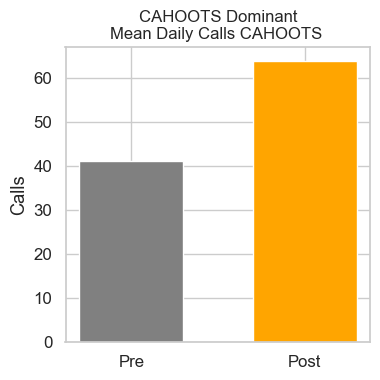

In [424]:
plt.figure(figsize=(4,4))
plt.bar(['Pre', 'Post'], [pre_calls, post_calls], color=['gray','orange'], width=0.6)
plt.title('CAHOOTS Dominant\nMean Daily Calls CAHOOTS ', fontsize=12)
plt.ylabel('Calls')
plt.tight_layout()
plt.show()

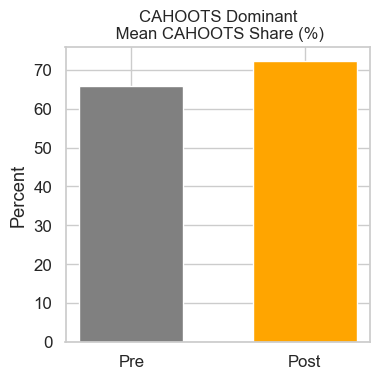

In [426]:
plt.figure(figsize=(4,4))
plt.bar(['Pre', 'Post'], [pre_share*100, post_share*100], color=['gray','orange'], width=0.6)
plt.title('CAHOOTS Dominant\n Mean CAHOOTS Share (%)', fontsize=12)
plt.ylabel('Percent')
plt.tight_layout()
plt.show()


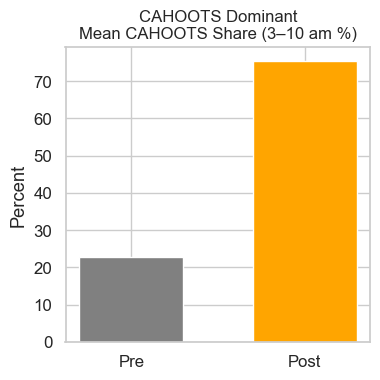

In [428]:
plt.figure(figsize=(4,4))
plt.bar(['Pre', 'Post'], [pre_share_3*100, post_share_3*100], color=['gray','orange'], width=0.6)
plt.title('CAHOOTS Dominant\nMean CAHOOTS Share (3–10 am %)', fontsize=12)
plt.ylabel('Percent')
plt.tight_layout()
plt.show()

In [430]:
# 7-day rolling share series
share = (daily_core_win_7d['CAHOOTS'] 
         / (daily_core_win_7d['CAHOOTS'] + daily_core_win_7d['NOT CAHOOTS'])
        )

# boolean mask & run-length encoding
mask = share >= 0.5
groups = (mask != mask.shift()).cumsum()
lengths = mask.groupby(groups).sum()[mask.groupby(groups).first()]

pd.DataFrame({
  'Metric': [
    'Longest Streak (days ≥50%)',
    'Number of Streaks',
    'Average Streak Length'
  ],
  'Value': [
    lengths.max(),
    len(lengths),
    lengths.mean()
  ]
})


Metric   Value
0  Longest Streak (days ≥50%)  2263.0
1           Number of Streaks    10.0
2       Average Streak Length   308.5

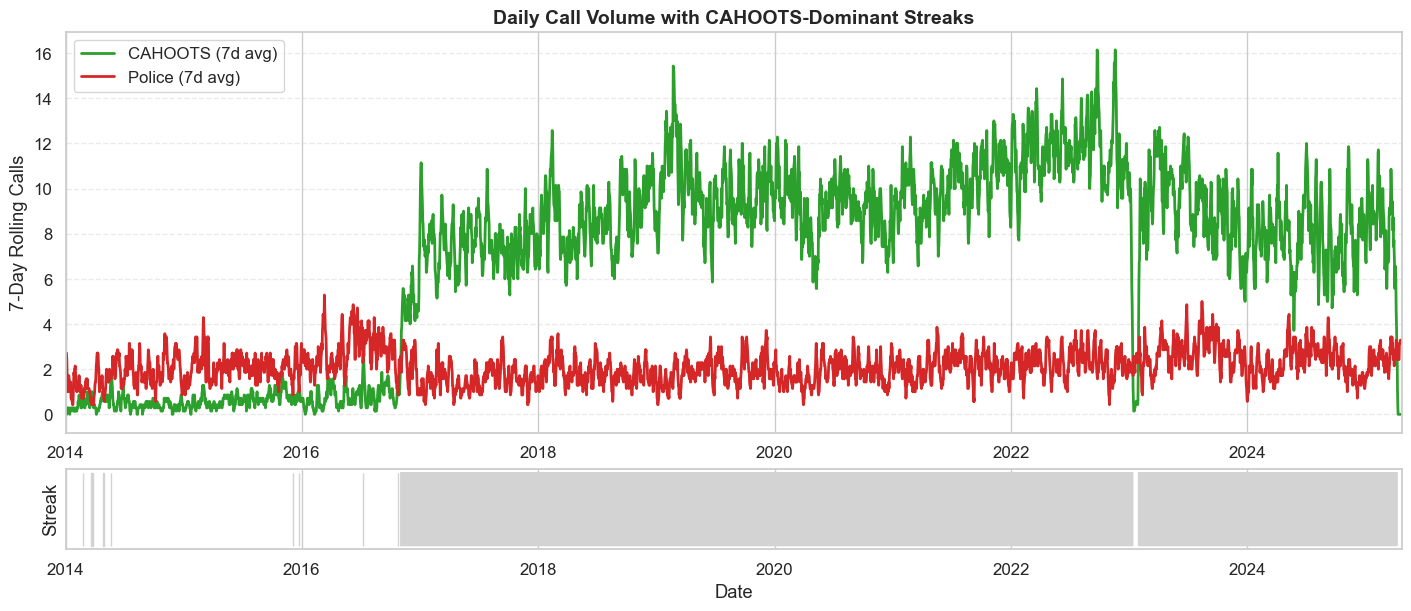

In [434]:
fig = plt.figure(constrained_layout=True, figsize=(14,6))
gs  = fig.add_gridspec(2,1, height_ratios=[5,1])

ax = fig.add_subplot(gs[0])
ax.plot(daily_core_win_7d.index, daily_core_win_7d['CAHOOTS'],
         color='tab:green', linewidth=2, label='CAHOOTS (7d avg)')
ax.plot(daily_core_win_7d.index, daily_core_win_7d['NOT CAHOOTS'],
         color='tab:red',   linewidth=2, label='Police (7d avg)')
ax.set_title('Daily Call Volume with CAHOOTS-Dominant Streaks', fontsize=14, weight='bold')
ax.set_ylabel('7-Day Rolling Calls')
ax.legend(loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.4)

# 4) Streak bar underneath
ax2 = fig.add_subplot(gs[1], sharex=ax)
ax2.fill_between(
    share.index,
    0, 1,
    where=mask,
    color='lightgrey'
)
ax2.set_yticks([])
ax2.set_ylabel('Streak')
ax2.set_xlim(daily_core_win_7d.index.min(), daily_core_win_7d.index.max())
ax2.set_xlabel('Date')

plt.show()

In [436]:
# pivot overall, restrict to core natures
pivot = (core_cahoots_df
         .groupby(['nature_clean','Unit Type'])
         .size()
         .unstack(fill_value=0)
        )
pivot['total'] = pivot.sum(axis=1)
pivot['share'] = pivot['CAHOOTS'] / pivot['total']

top10 = (pivot
        .loc[pivot.index.isin(core_cahoots_df['nature_clean'])]
        .sort_values('total', ascending=True)
        .head(10)
        [['total','share']]
       )
top10


Unit Type            total     share
nature_clean                        
EMERGENCY MESSAGE      155  0.561290
DEATH MESSAGE          326  0.429448
POISONING              446  0.051570
ASSIST FD              721  0.944521
DISORIENTED SUBJECT   2072  0.652992
INFO / ATL            2187  0.886145
ASSIST PD             2273  0.956885
FOUND SYRINGE         3445  0.714078
INTOXICATED SUBJECT   5548  0.647801
PUBLIC ASSIST        19926  0.962160

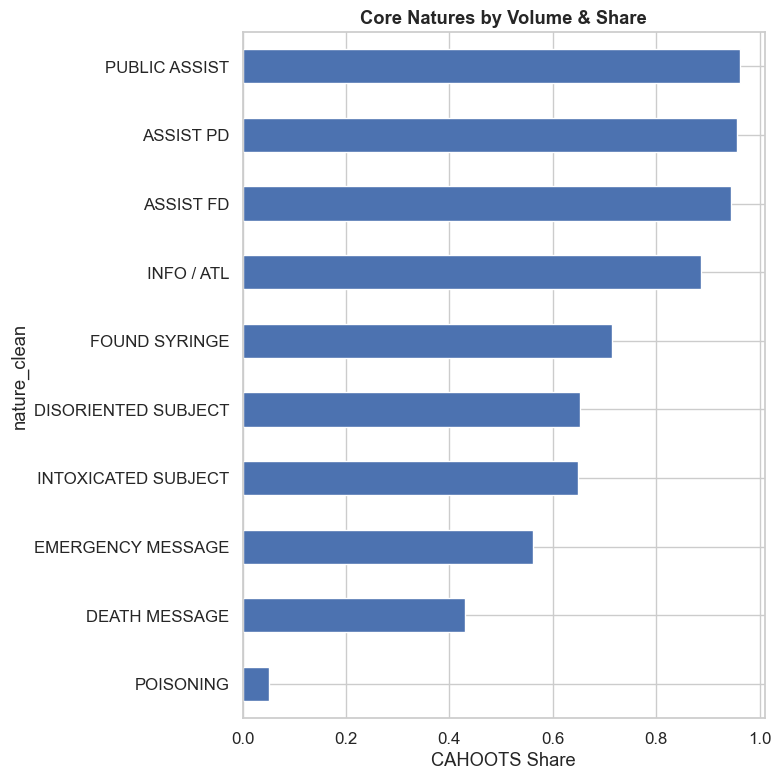

In [440]:
# barh of share
ax = top10.sort_values("share")["share"].plot.barh(figsize=(8, 8))
ax.set_xlabel("CAHOOTS Share")
ax.set_title("Core Natures by Volume & Share", weight="bold")
plt.tight_layout()

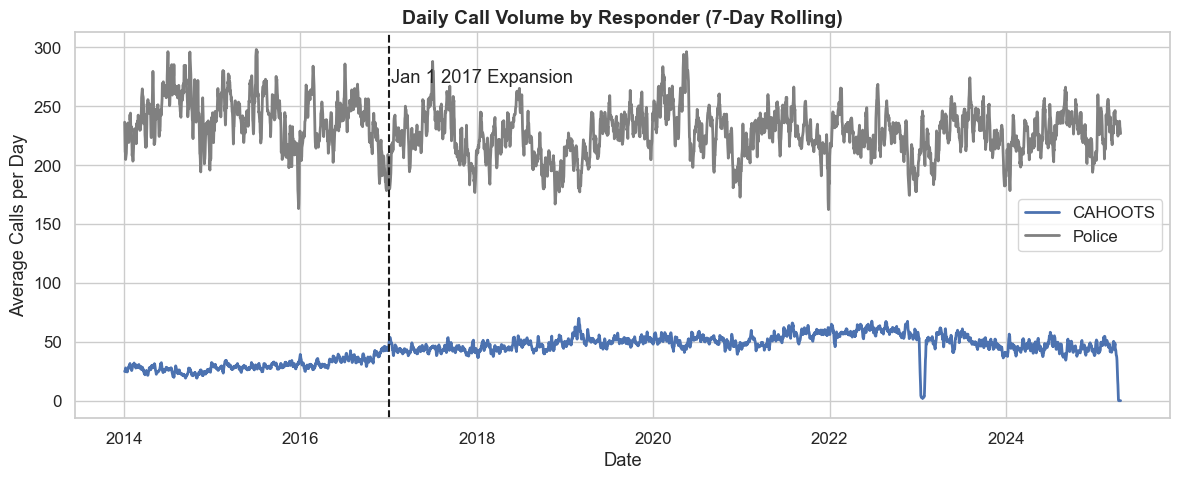

In [247]:
daily_vol = master_df.groupby(['date','Unit Type']).size().unstack(fill_value=0)

# 2. Smooth with a 7-day centered rolling average
vol_sm = daily_vol.rolling(window=7, center=True).mean()

# 3. Plot
plt.close('all')
fig, ax = plt.subplots(figsize=(12,5))
vol_sm['CAHOOTS'].plot(ax=ax, linewidth=2, label='CAHOOTS')
vol_sm['NOT CAHOOTS'].plot(ax=ax, linewidth=2, label='Police', color='gray')

# 4. Annotate expansion date
ax.axvline(EXPANSION_DATE, color='k', linestyle='--')
ymax = ax.get_ylim()[1]
ax.text(EXPANSION_DATE + pd.Timedelta(days=10), ymax*0.9,
        'Jan 1 2017 Expansion', ha='left', va='top')

# 5. Formatting
ax.set_title('Daily Call Volume by Responder (7-Day Rolling)', fontsize=14, weight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Average Calls per Day')
ax.legend()
plt.tight_layout()
plt.show()

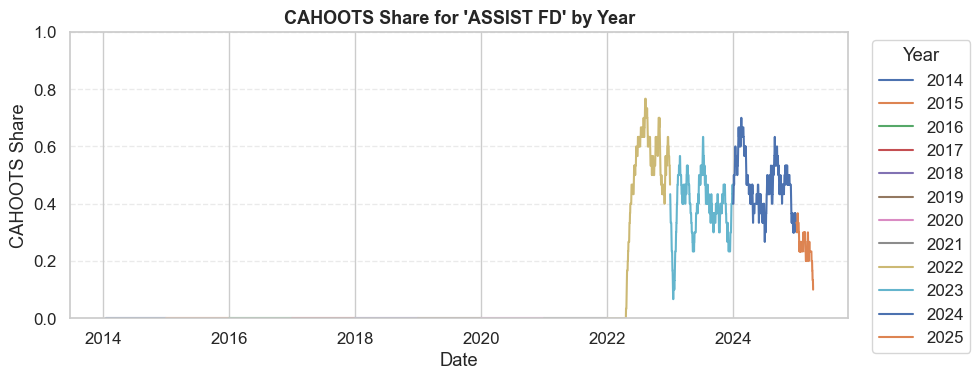

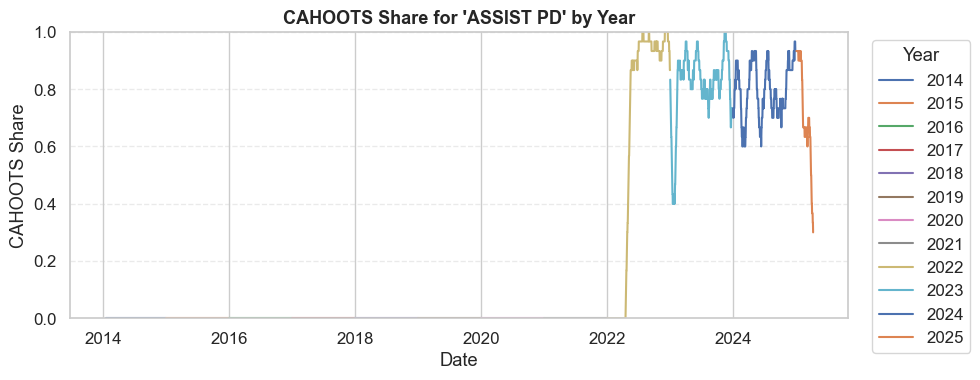

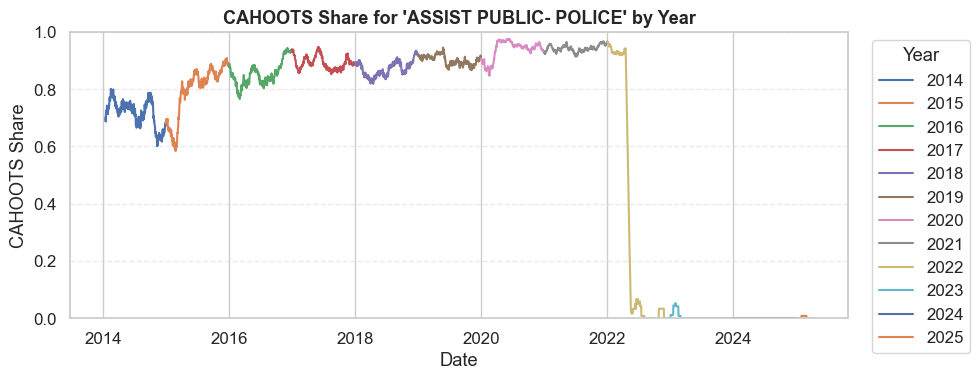

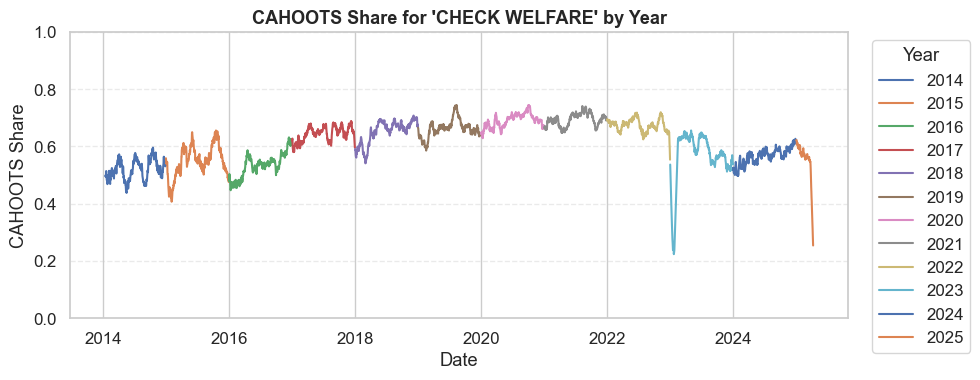

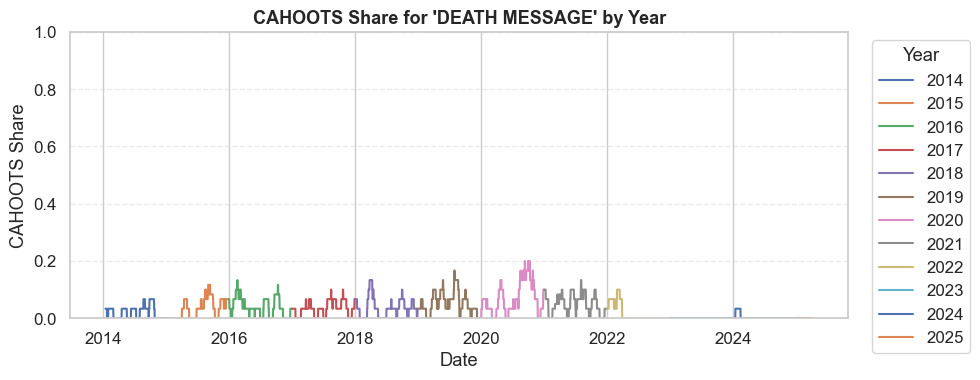

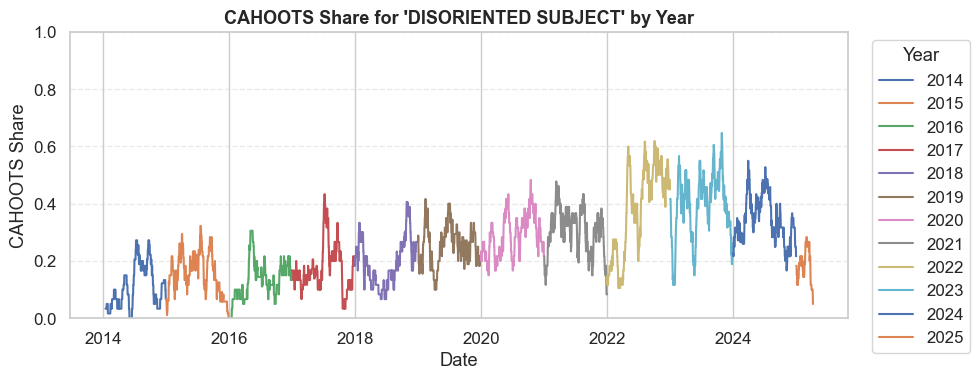

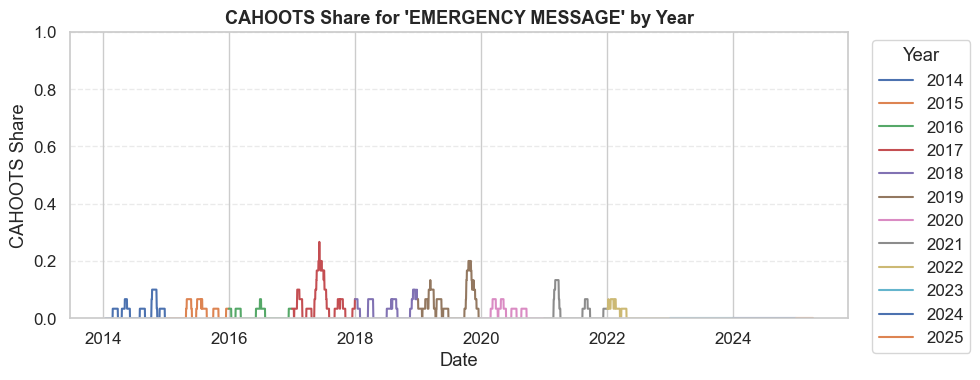

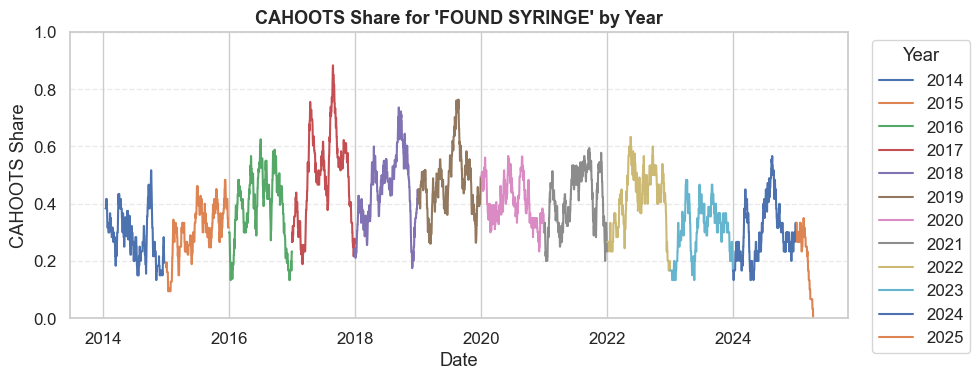

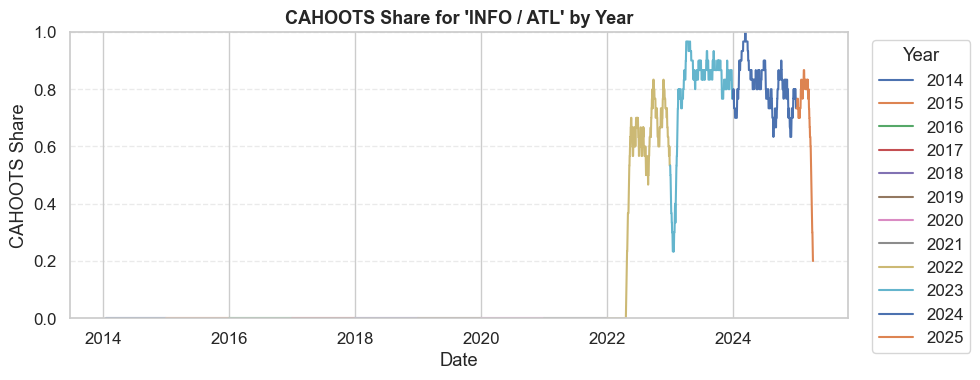

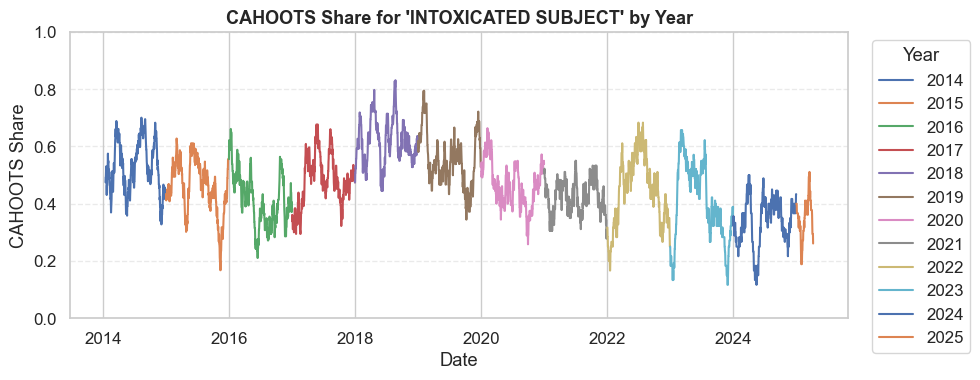

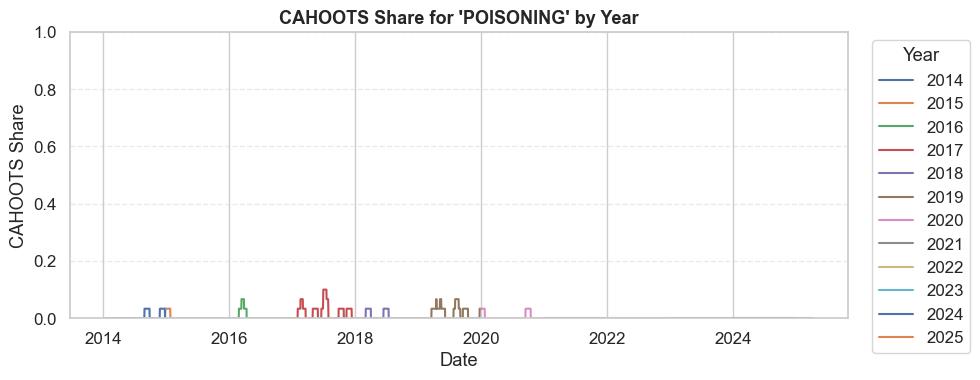

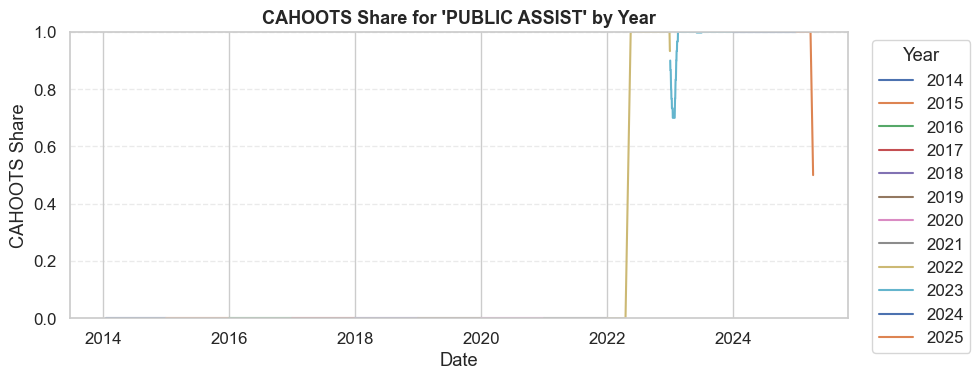

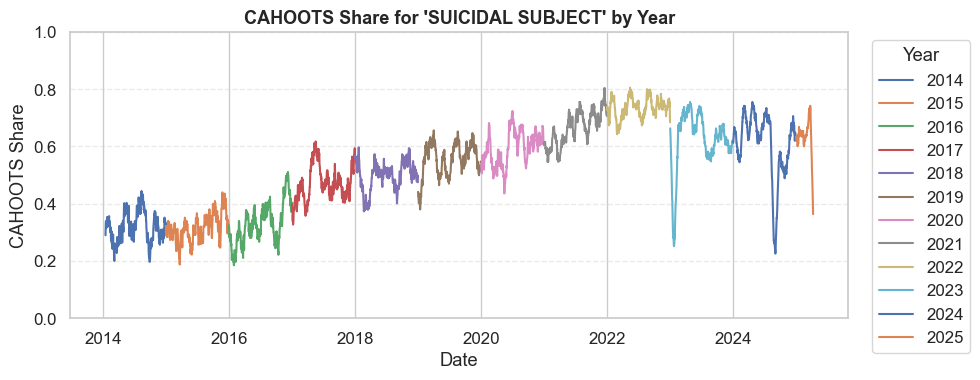

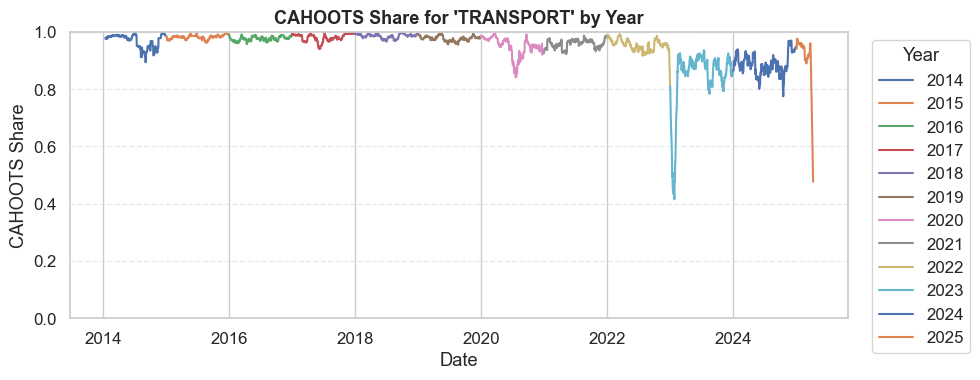

In [442]:
daily_nature = (
    core_cahoots_df
    .groupby(['date', 'yr', 'nature_clean', 'Unit Type'])
    .size()
    .unstack(fill_value=0)
)

# Compute share of CAHOOTS
daily_nature['share'] = (
    daily_nature['CAHOOTS'] /
    (daily_nature['CAHOOTS'] + daily_nature['NOT CAHOOTS'])
)

# Pivot so each nature gets its own column
share_pivot = daily_nature['share'].unstack('nature_clean').fillna(0)

# Smooth with 7-day centered rolling average
share_sm = share_pivot.rolling(window=30, center=True).mean()

share_df = (
    share_sm
    .reset_index()                   # brings 'date' & 'yr' into columns
    .rename(columns={'level_0':'date', 'level_1':'yr'})  # if needed
)

# 2. Ensure 'date' is datetime
share_df['date'] = pd.to_datetime(share_df['date'])

# 3. Loop over each nature
natures = share_sm.columns
years   = sorted(share_df['yr'].unique())

for nature in natures:
    plt.figure(figsize=(10, 4))
    for yr in years:
        sub = share_df[share_df['yr'] == yr]
        plt.plot(
            sub['date'],
            sub[nature],
            label=str(yr),
            linewidth=1.5
        )
    plt.title(f"CAHOOTS Share for '{nature}' by Year",
              fontsize=13, weight='bold')
    plt.xlabel("Date")
    plt.ylabel("CAHOOTS Share")
    plt.ylim(0,1)
    plt.legend(title="Year", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

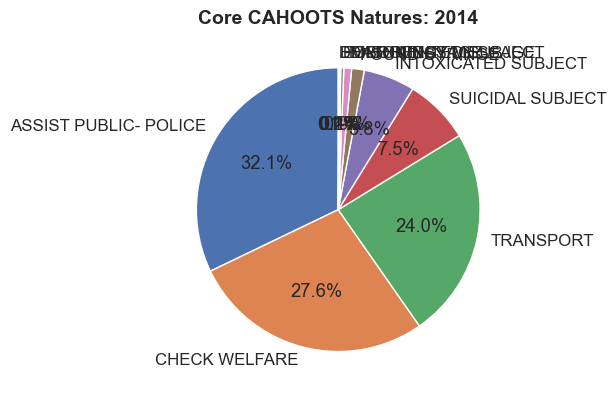

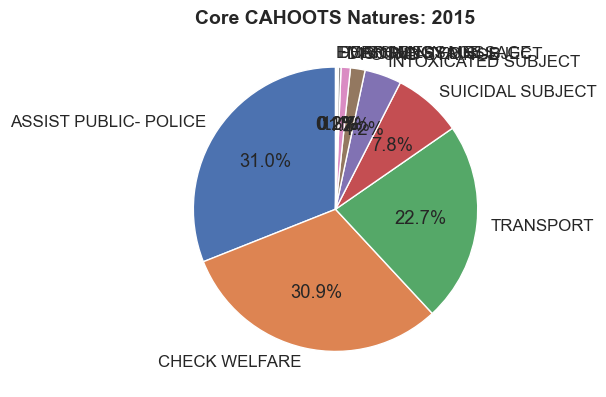

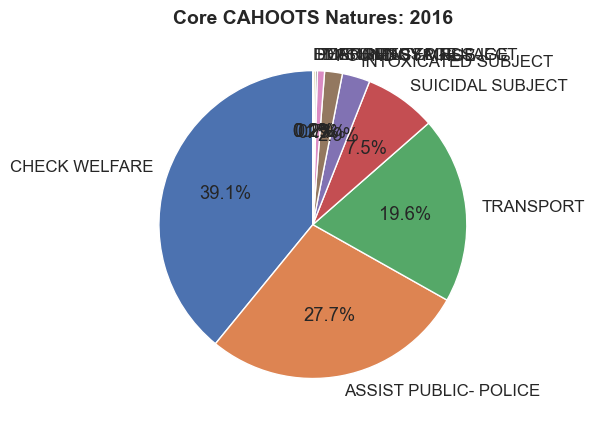

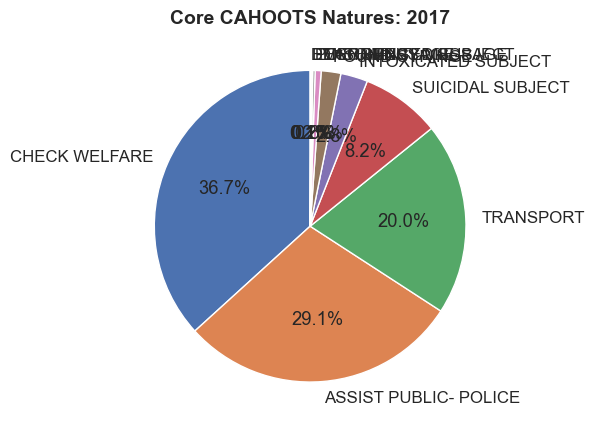

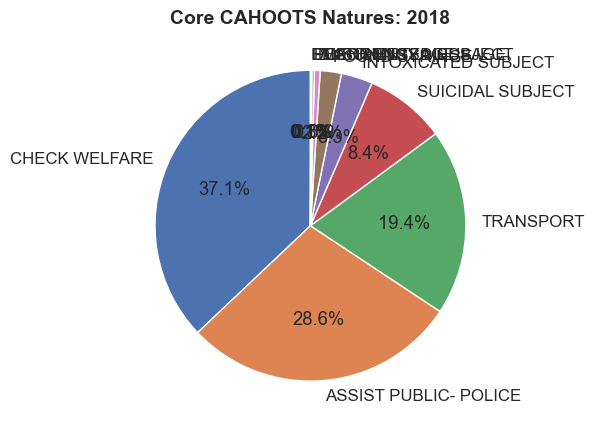

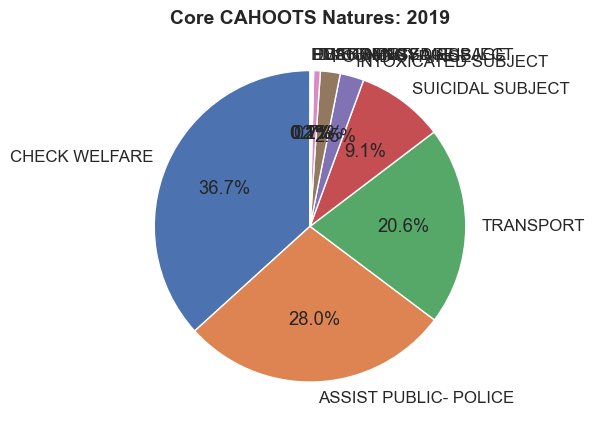

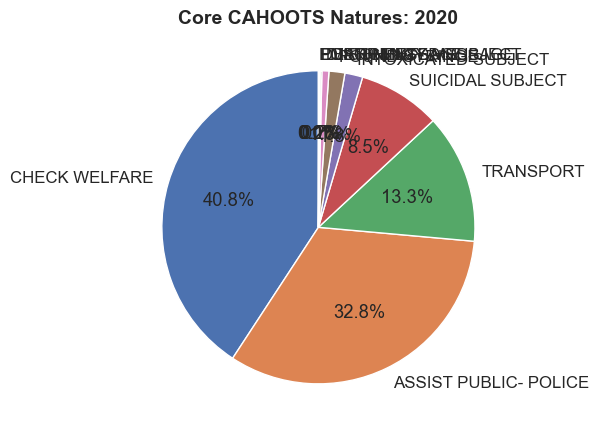

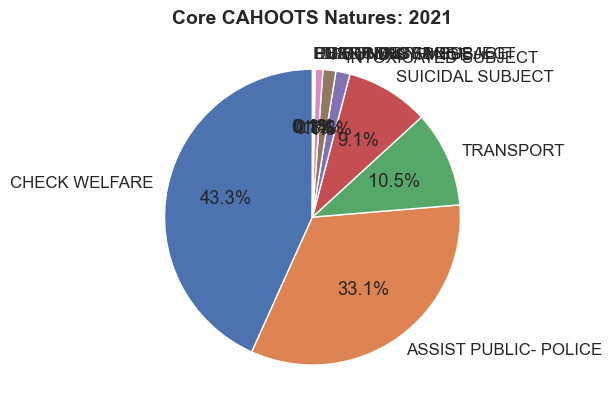

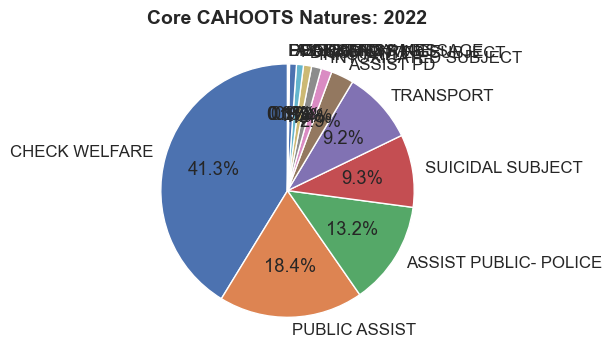

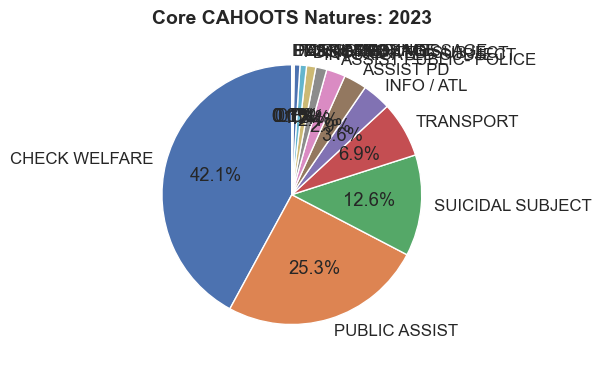

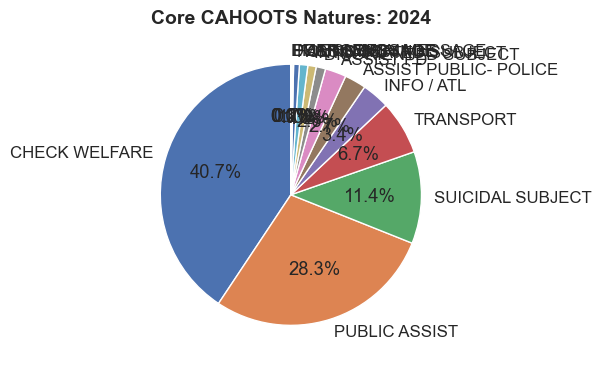

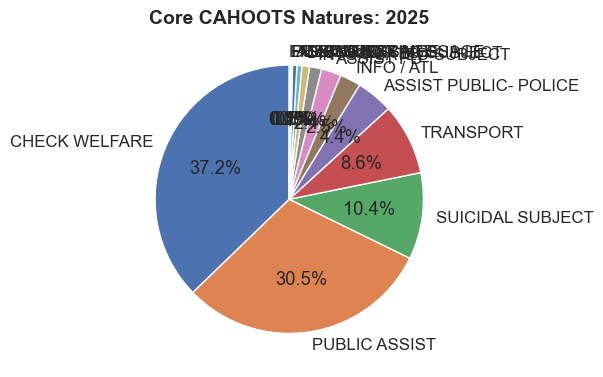

In [454]:
core_cahoots_df['date'] = pd.to_datetime(core_cahoots_df['date'])
years = sorted(core_cahoots_df['date'].dt.year.unique())

years = sorted(core_cahoots_df['date'].dt.year.unique())
n_years = len(years)

# Loop over each year and draw a separate pie chart (one figure per year)
for yr in years:
    # 1) Filter to just this year
    yearly_data = core_cahoots_df[core_cahoots_df['date'].dt.year == yr]
    
    # 2) Count occurrences of each 'nature_clean'
    counts = yearly_data['nature_clean'].value_counts()
    
    # 3) Create a new figure & axis for this year
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # 4) Draw the pie chart
    ax.pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%',
        startangle=90
    )
    ax.set_title(f"Core CAHOOTS Natures: {yr}", fontsize=14, weight='bold')
    
    # 5) Tight layout and show
    plt.tight_layout()
    plt.show()

In [464]:
pip install squarify

Note: you may need to restart the kernel to use updated packages.


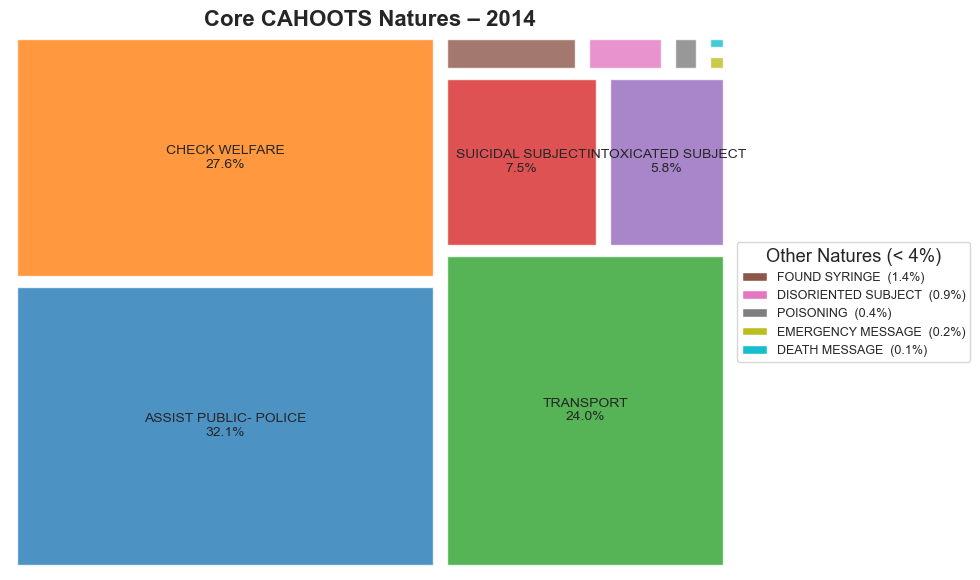

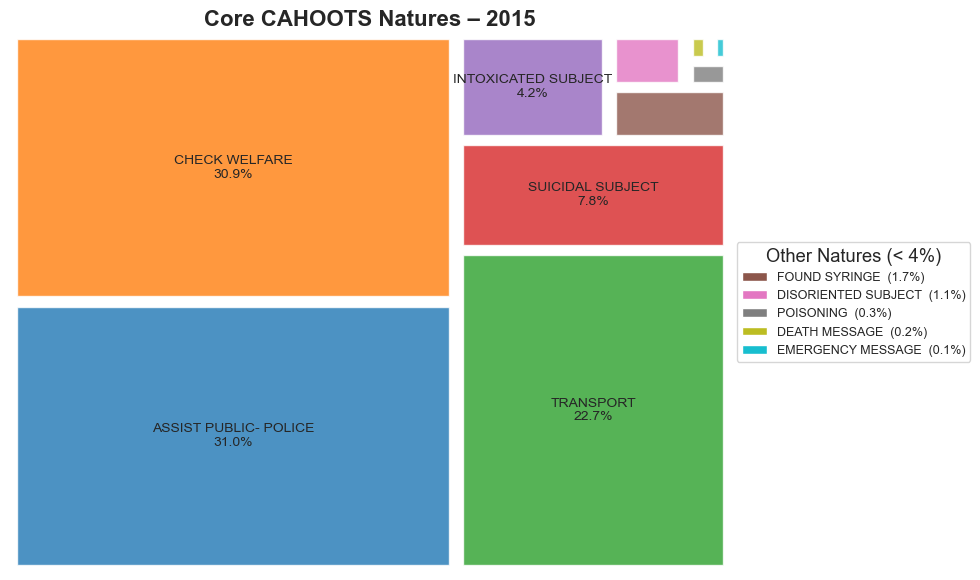

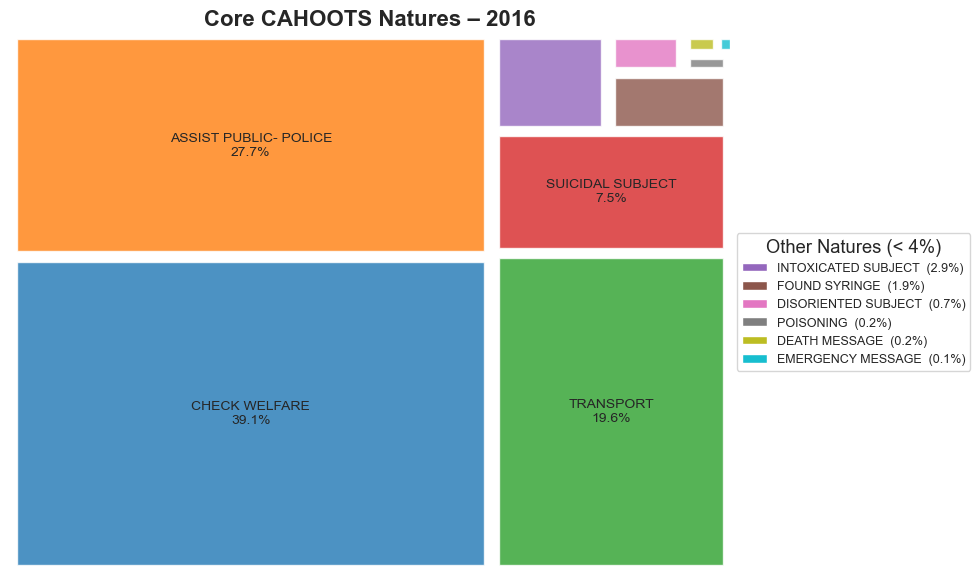

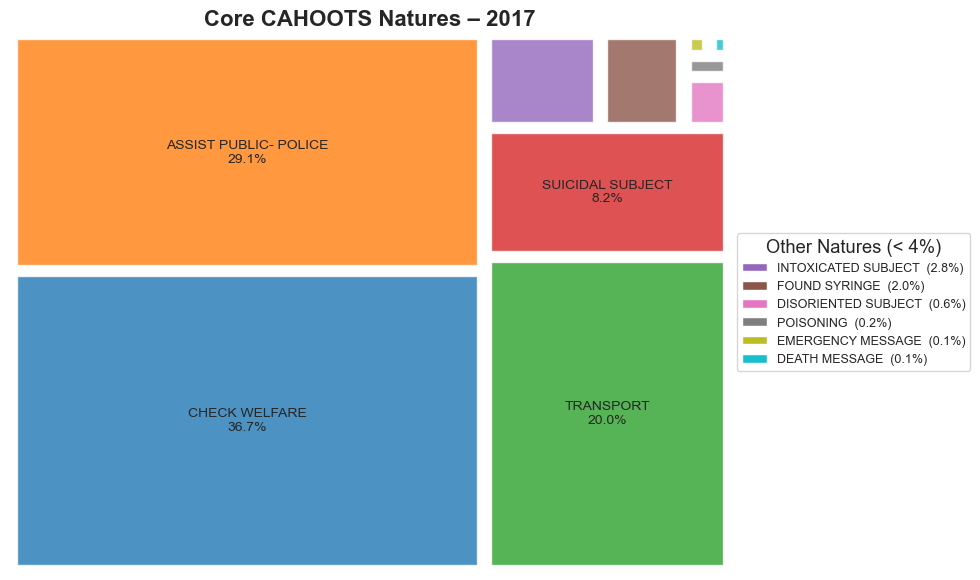

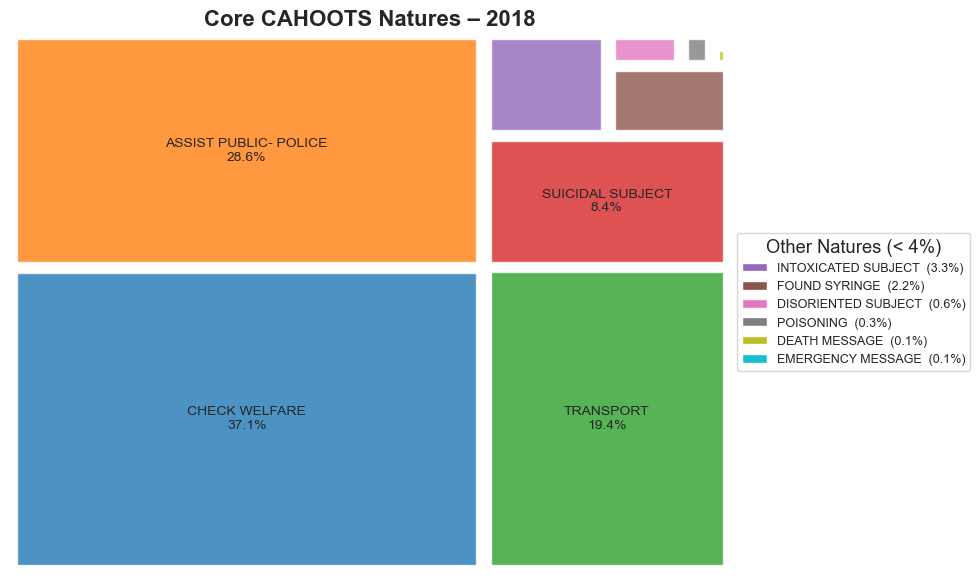

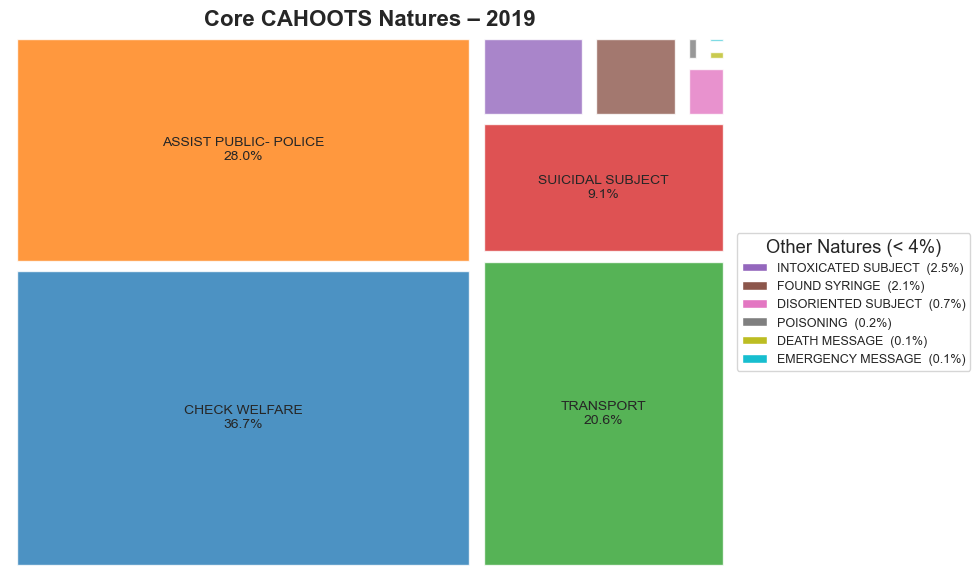

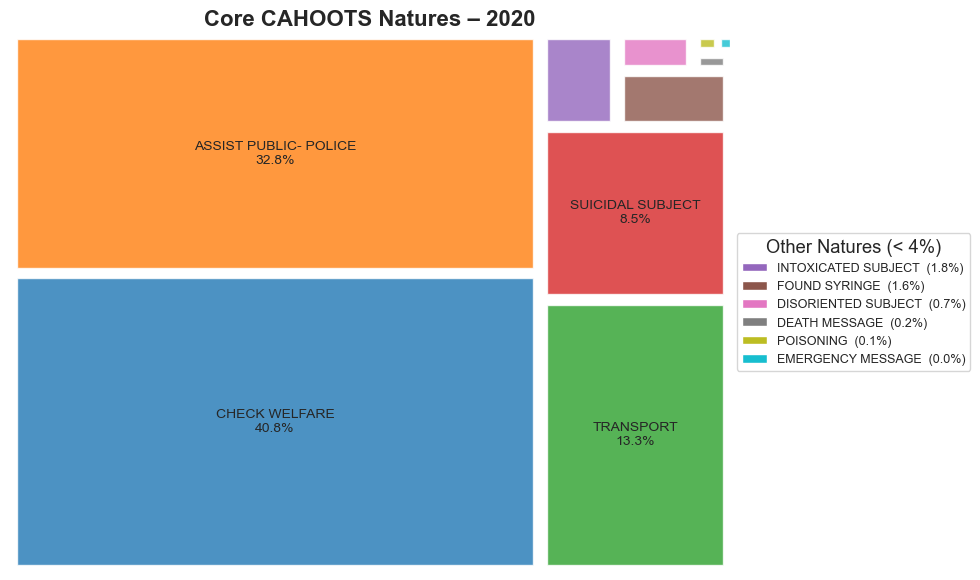

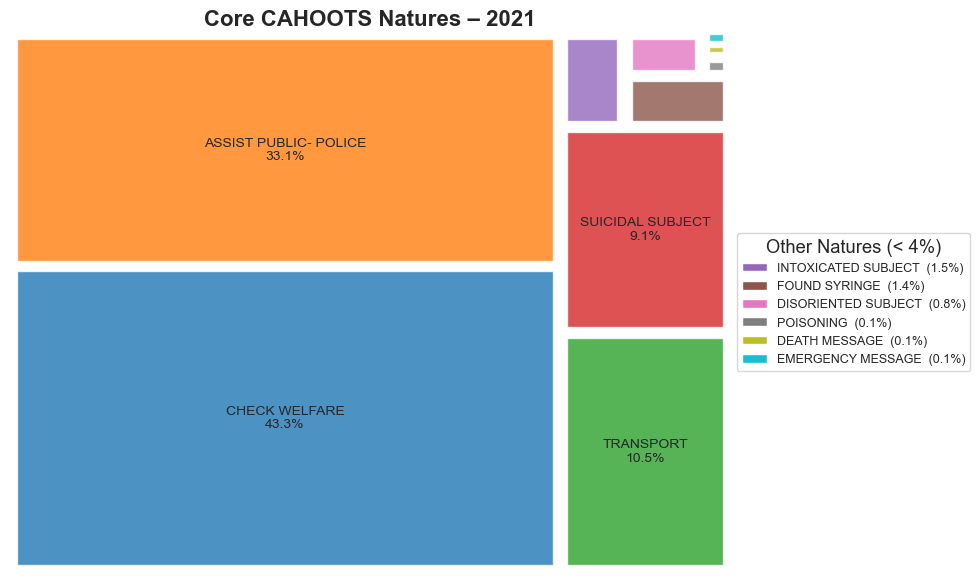

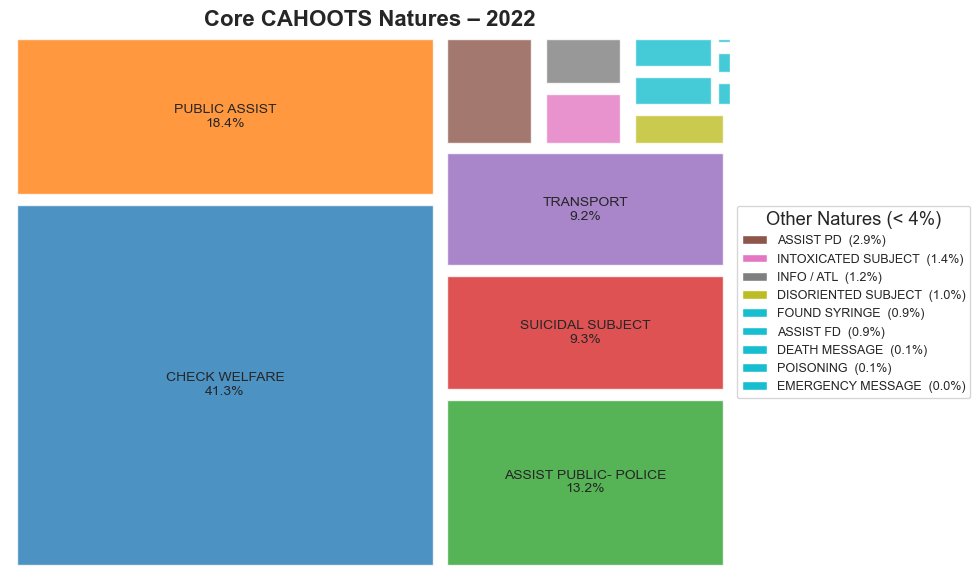

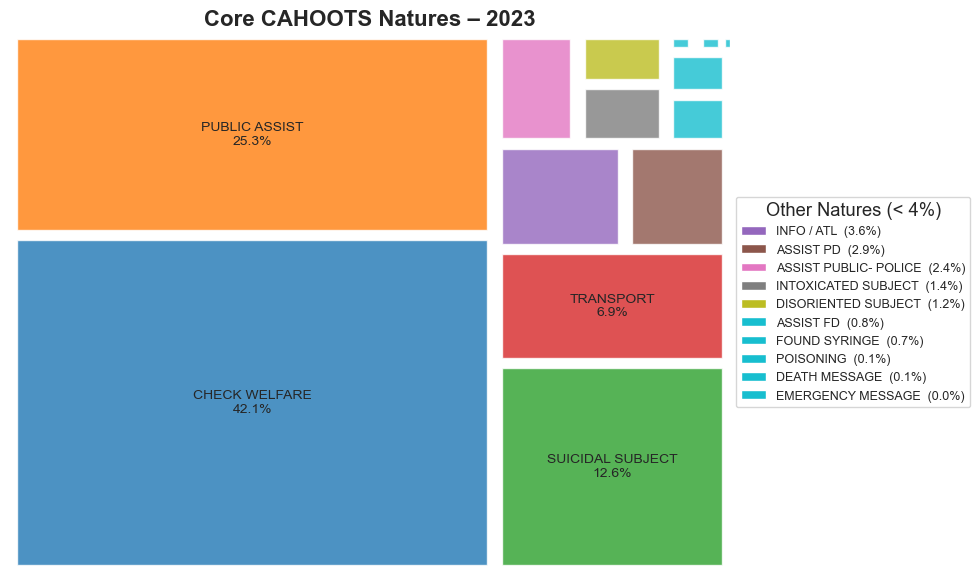

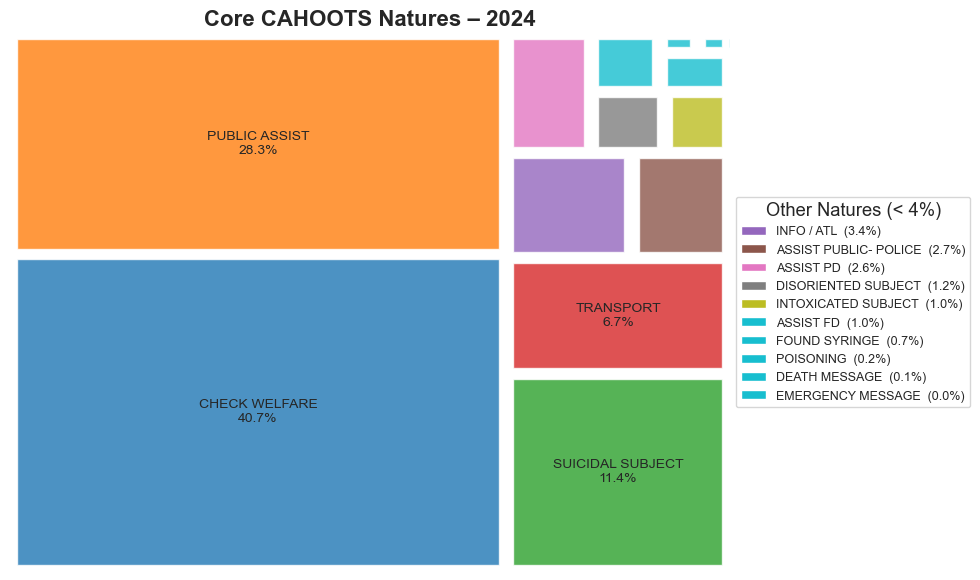

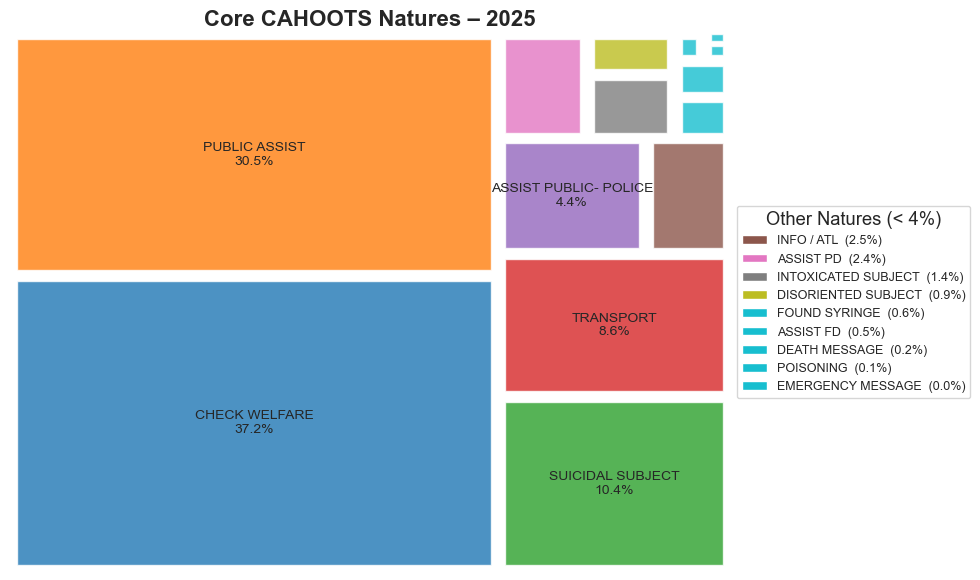

In [480]:
import squarify
label_threshold = 0.04

for year_to_plot in years:
    # 4.1) Subset the DataFrame for that year
    df_year = core_cahoots_df[core_cahoots_df['date'].dt.year == year_to_plot].copy()
    
    # 4.2) Compute counts of each 'nature_clean'
    counts = df_year['nature_clean'].value_counts()
    
    # 4.3) Build a small DataFrame so we can compute share
    summary = counts.rename_axis('nature').reset_index(name='count')
    summary['share'] = summary['count'] / summary['count'].sum()
    
    # 4.4) Sort descending by share so largest rectangles appear first
    summary = summary.sort_values('share', ascending=False).reset_index(drop=True)
    
    # 4.5) Prepare the “sizes” list for squarify (they should sum to > 0)
    sizes = summary['share'].tolist()
    
    # 4.6) Build a list of labels:  
    #     - If share ≥ threshold: “Nature\nxx.x%”  
    #     - Otherwise: “” (blank)
    labels = []
    for idx, row in summary.iterrows():
        pct = row['share'] * 100
        if row['share'] >= label_threshold:
            labels.append(f"{row['nature']}\n{pct:.1f}%")
        else:
            labels.append("")
    
    # 4.7) Pick a color palette. We'll use tab20c to ensure enough distinct colors.
    colors = plt.cm.tab10(range(len(sizes)))
    
    # 4.8) Start plotting this year’s treemap
    fig, ax = plt.subplots(figsize=(10, 6))
    squarify.plot(
        sizes=sizes,
        label=labels,
        color=colors,
        alpha=0.8,
        pad=True,                  # small gap between rectangles
        text_kwargs={'fontsize': 10}
    )
    
    # 4.9) Build a legend for all “small” categories (share < threshold)
    small_items = summary[summary['share'] < label_threshold]
    if not small_items.empty:
        handles = []
        leg_labels = []
        for _, row in small_items.iterrows():
            # Find the index of this row in summary to match its color
            idx_in_summary = summary.index.get_loc(row.name)
            patch = plt.Rectangle((0, 0), 1, 1, facecolor=colors[idx_in_summary])
            handles.append(patch)
            leg_labels.append(f"{row['nature']}  ({row['share']*100:.1f}%)")
        
        ax.legend(
            handles,
            leg_labels,
            title=f"Other Natures (< {label_threshold*100:.0f}%)",
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            fontsize=9
        )
    
    # 4.10) Final title & styling
    ax.set_title(f"Core CAHOOTS Natures – {year_to_plot}", fontsize=16, weight='bold')
    ax.axis('off')  # hide axes
    plt.tight_layout()
    plt.show()

In [ ]:
### 